# 4.1 Interpolation - Bald Mountain (BM)

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import combinations

from scipy.stats import ttest_1samp, t

from pykrige.ok import OrdinaryKriging
from pykrige.rk import Krige
import pykrige.kriging_tools as kt

from sklearn.model_selection import cross_val_predict

from joblib import Parallel, delayed
import multiprocessing

In [2]:
import prepostprocessing.pre_processing as preproc
import prepostprocessing.post_processing as postproc
import nugget_estimation.kriging_tools as krigingtools
import nugget_estimation.detrending as detrending
import plots.plots as plots
import statistics.ttest as ttest
import prepostprocessing.cleaning as cleaning
import cross_validation.leave_one_out_cross_validation as loocv
import qapf.qapf as qapf
import statistics.simulations as sim

import toolbox.toolbox as tb

In [3]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readtheBMcs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [4]:
coordinates_clean = preproc.load_obj("coordinates_clean")
coordinates_clean_utm = preproc.load_obj("coordinates_clean_utm")
mineralogy_clean_uniform = preproc.load_obj("mineralogy_clean_uniform")
mineralogy_clean_clr_uniform = preproc.load_obj("mineralogy_clr_uniform")
mineralogy_pca_uniform = preproc.load_obj("mineralogy_pca_uniform")
mineralogy_pca_df_uniform = preproc.load_obj("mineralogy_pca_df_uniform")
coordinates_grids = preproc.load_obj("coordinates_grids")
coordinates_grids_wide = preproc.load_obj("coordinates_grids_wide")

___

## EDA

In [5]:
pca_BM = mineralogy_pca_uniform["BM"]
mineralogy_pca_BM = mineralogy_pca_df_uniform["BM"]
mineralogy_clr_BM = mineralogy_clean_clr_uniform["BM"]

coordinates_BM = coordinates_clean["BM"]
coordinates_utm_BM = coordinates_clean_utm["BM"].drop_duplicates()
grid_BM = coordinates_grids["BM"]
grid_wide_BM = coordinates_grids_wide["BM"]

In [6]:
number_of_control_points_BM = coordinates_utm_BM.shape[0]
number_of_control_points_BM

130

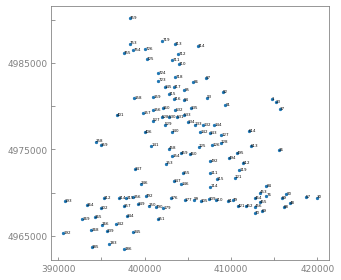

In [7]:
plots.plot_map_with_control_points(coordinates_utm_BM, "BM", label_size=4,
                                  skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1)

In [7]:
coordinates_utm_BM["zoneNumber"].unique()
coordinates_utm_BM["zoneLetter"].unique()

array([11], dtype=int64)

array(['T'], dtype=object)

In [8]:
min_lag_distance_BM = np.amin(krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm_BM[["X", "Y"]]))
max_lag_distance_BM = np.amax(krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm_BM[["X", "Y"]]))
min_lag_distance_BM, max_lag_distance_BM

(612.811775698614, 30002.800008747647)

## Nugget calculation based on replicates

In [9]:
replicates_BM = pd.read_csv("../_DATA/Bald_Mountain/Bald_Mountain_Taubeneck_(1957)_mineralogy_replicates.csv", sep=";", index_col=0)

In [10]:
replicates_BM

K     Q     P    H    B    A
Sample                                    
BM_repl_1   8.8  26.5  53.9  3.2  6.9  0.7
BM_repl_1   7.5  27.2  53.2  2.9  8.3  0.9
BM_repl_1   6.1  27.1  54.4  3.8  7.3  1.3
BM_repl_1   7.6  27.0  57.4  3.9  3.5  0.6
BM_repl_1   7.6  27.4  55.6  3.0  5.7  0.7
460        19.3  32.9  44.7  0.0  2.9  0.2
460        22.1  32.6  42.4  0.0  2.8  0.1
466        28.6  36.3  33.1  0.0  1.9  0.1
466        26.0  37.3  34.9  0.0  1.5  0.3
490        26.6  36.3  35.8  0.0  1.1  0.2
490        30.8  35.6  32.7  0.0  0.7  0.2
BM_repl_2   8.8  26.5  53.9  6.9  3.2  0.7
BM_repl_2   9.1  26.7  53.5  6.8  3.4  0.5
BM_repl_2   9.1  26.2  53.6  7.3  3.0  0.8

In [11]:
replicates_BM = replicates_BM.drop("BM_repl_2")
replicates_BM

K     Q     P    H    B    A
Sample                                    
BM_repl_1   8.8  26.5  53.9  3.2  6.9  0.7
BM_repl_1   7.5  27.2  53.2  2.9  8.3  0.9
BM_repl_1   6.1  27.1  54.4  3.8  7.3  1.3
BM_repl_1   7.6  27.0  57.4  3.9  3.5  0.6
BM_repl_1   7.6  27.4  55.6  3.0  5.7  0.7
460        19.3  32.9  44.7  0.0  2.9  0.2
460        22.1  32.6  42.4  0.0  2.8  0.1
466        28.6  36.3  33.1  0.0  1.9  0.1
466        26.0  37.3  34.9  0.0  1.5  0.3
490        26.6  36.3  35.8  0.0  1.1  0.2
490        30.8  35.6  32.7  0.0  0.7  0.2

In [12]:
replicates_BM = cleaning.combine_rest_minerals(replicates_BM)

In [13]:
replicates_BM.to_excel("../_RESULTS/replicates_data/BM_replicates_data_new.xlsx")

In [13]:
replicates_clr_BM = tb.clr(replicates_BM)

In [15]:
replicates_clr_BM.groupby(level=0).var(ddof=1).to_excel("../_RESULTS/replicates_data/BM_replicates_sample_variance_clr_new.xlsx")

In [14]:
# Take the mean of each set of replicates and create new dataset of these means
replicates_clr_BM_mean = replicates_clr_BM.groupby(level=0).mean()

In [15]:
# Combine these means with the non-replicate samples
mineralogy_clr_BM_non_replicates_and_replicates_mean = pd.concat([mineralogy_clr_BM, replicates_clr_BM_mean], sort=False)
mineralogy_clr_BM_non_replicates_and_replicates_mean.shape

(134, 4)

In [16]:
# PCA
pca_combined = preproc.pca(mineralogy_clr_BM_non_replicates_and_replicates_mean)
pca_combined_df = preproc.create_pca_df(pca_combined, mineralogy_clr_BM_non_replicates_and_replicates_mean)
pca_combined.explained_variance_ratio_

array([9.57353506e-01, 3.86795337e-02, 3.96696053e-03, 8.81010103e-32])

In [17]:
# Center replicates with their set mean
mineralogy_clr_BM_replicates_centered = replicates_clr_BM - replicates_clr_BM_mean

In [18]:
# Transform centered clrs to existing PCA
pca_replicates_centered_transformed  = pd.DataFrame(pca_combined.transform(mineralogy_clr_BM_replicates_centered),
                                                        index=mineralogy_clr_BM_replicates_centered.index,
                                                        columns=pca_combined_df.columns)

In [19]:
nugget_replicates_BM = krigingtools.calculate_nugget(pca_replicates_centered_transformed)

In [20]:
nugget_replicates_BM

PC01    2.301353e-02
PC02    1.688698e-02
PC03    2.707721e-03
PC04    1.792004e-31
dtype: float64

___

## Critical distance estimation

Determine the search radius at which ca. 95% of the control points have three neighbourse within the chosen search radius.

In [23]:
plots.interactive_plot_search_radius(coordinates_utm_BM, radius_min=1000, radius_max=10000, radius_step=200, radius_default=3800)

interactive(children=(IntSlider(value=3800, description='search_radius', max=10000, min=1000, step=200), Outpu…

In [21]:
critical_distance_BM = 3800

In [22]:
range_BM = [12000, 12000, 12000]

In [23]:
nvalues_control_points_BM = {}

for radius in (critical_distance_BM, range_BM[0]):
    temp = krigingtools.find_points_within_search_radius(
               krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm_BM),
               search_radius=radius
           )
    nvalues_control_points_BM[radius] = pd.Series(temp, index=coordinates_utm_BM.index)

In [24]:
samples_outside_critical_distance_BM = nvalues_control_points_BM[3800][nvalues_control_points_BM[3800] < 3].index.tolist()
samples_outside_critical_distance_BM

[1, 23, 258, 26, 359, 37, 759]

In [25]:
mineralogy_pca_BM.loc[samples_outside_critical_distance_BM, :]

PC01      PC02      PC03          PC04
1   -0.290712 -0.000586 -0.122086  4.302114e-16
23   1.078965 -0.073590 -0.086495  3.330669e-16
258  2.599191  0.294282  0.088757 -2.220446e-16
26   2.721621 -0.369785 -0.029401 -4.440892e-16
359  0.329134 -0.258106 -0.006339 -1.665335e-16
37   2.646065 -0.046414 -0.086393  7.771561e-16
759 -1.110338  0.023967  0.125464 -4.440892e-16

## QAPF map

In [25]:
mineralogy_BM = postproc.reverse_clr(mineralogy_clr_BM, mineralogy_clr_BM)
mineralogy_BM.shape

(130, 4)

In [26]:
mineralogy_BM["QAPF"], points_BM = qapf.check_QAPF_region(mineralogy_BM, return_points=True)

In [28]:
mineralogy_BM.head()

Q          P          K     Others          QAPF
1    24.075924  60.139860   2.697303  13.086913      tonalite
105  20.600000  61.700000   0.600000  17.100000      tonalite
109  25.400000  60.100000   0.300000  14.200000      tonalite
110  23.053892  64.071856   0.099800  12.774451      tonalite
111  25.600000  52.300000  10.700000  11.400000  granodiorite

In [29]:
preproc.save_obj(mineralogy_BM, "BM/mineralogy_BM")

In [27]:
QAPF_to_plot_BM = pd.merge(coordinates_utm_BM, mineralogy_BM[["QAPF"]], left_index=True, right_index=True)

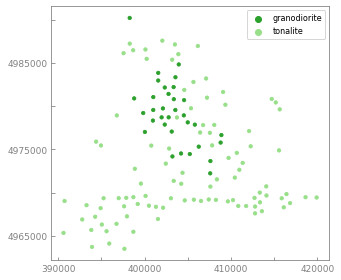

In [28]:
plots.plot_qapf_map(QAPF_to_plot_BM, "BM", label_size=4, plot_labels=False,
                    skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1)

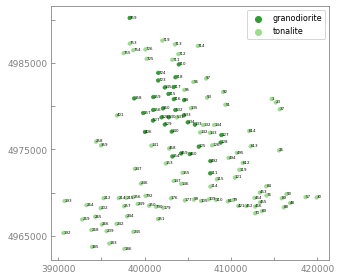

In [29]:
plots.plot_qapf_map(QAPF_to_plot_BM, "BM", label_size=4, plot_labels=True,
                    skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1)

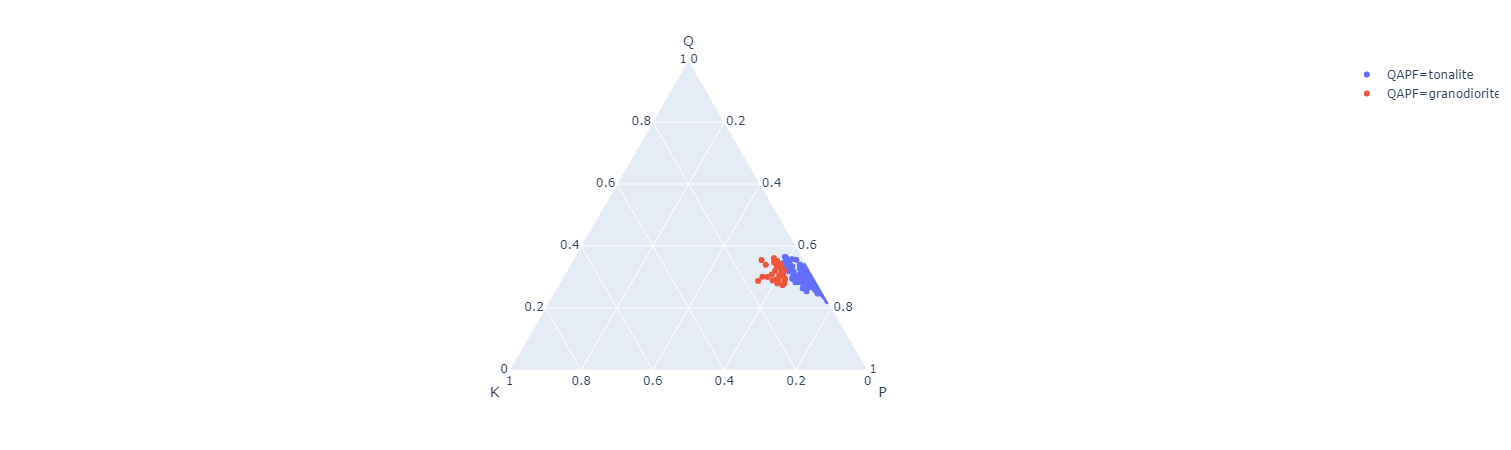

In [30]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter_ternary(mineralogy_BM, a="Q", b="K", c="P", color="QAPF")

# # Add shapes
# fig.update_layout(
#     shapes=[
#         # Quartz 90% line
#         go.layout.Shape(type="line",
#                         x0=0.465, y0=0.90,
#                         x1=0.515, y1=0.90,
#                         line=dict(color="grey", width=1)
#                        ),
        
#         # Quartz 60% line
#         go.layout.Shape(type="line",
#                         x0=0.585, y0=0.60,
#                         x1=0.395, y1=0.60,
#                         line=dict(color="grey", width=1)
#                        ),
        
#         # Quartz 20% line
#         go.layout.Shape(type="line",
#                         x0=0.6865, y0=0.20,
#                         x1=0.2975, y1=0.20,
#                         line=dict(color="grey", width=1)
#                        ),
        
#         # Quartz 5% line
#         go.layout.Shape(type="line",
#                         x0=0.72, y0=0.05,
#                         x1=0.26, y1=0.05,
#                         line=dict(color="grey", width=1)
#                        ),
#         # Plagioclase 10% line
#         go.layout.Shape(type="line",
#                         x0=0.41, y0=0.60,
#                         x1=0.29, y1=0.00,
#                         line=dict(color="grey", width=1)
#                        ),
        
#         # Plagioclase 90% line
#         go.layout.Shape(type="line",
#                         x0=0.57, y0=0.60,
#                         x1=0.69, y1=0.00,
#                         line=dict(color="grey", width=1)
#                        ),
        
#         # Plagioclase 35% line
#         go.layout.Shape(type="line",
#                         x0=0.46, y0=0.60,
#                         x1=0.4175, y1=0.00,
#                         line=dict(color="grey", width=1)
#                        ),
#         # Plagioclase 65% line
#         go.layout.Shape(type="line",
#                         x0=0.52, y0=0.60,
#                         x1=0.5625, y1=0.00,
#                         line=dict(color="grey", width=1)
#                        ),
#     ]
# )

fig.write_image("../_FIGURES/qapf_diagrams/BM_qapf_diagram.pdf")
fig.show()

## Detrending

In [23]:
for component in mineralogy_pca_BM.columns.tolist()[:-1]:
    for order in [1, 2]:
        print("R² for", component, "order =", order, ":")
        detrending.detrend(coordinates_utm_BM, mineralogy_pca_BM[component], order=order, verbose=False, plot_points=False)[1]

R² for PC01 order = 1 :


0.17680800892663406

R² for PC01 order = 2 :


0.26892023389999886

R² for PC02 order = 1 :


0.07671878939854726

R² for PC02 order = 2 :


0.09826013435270431

R² for PC03 order = 1 :


0.04391239979842976

R² for PC03 order = 2 :


0.04458333222375477

## Variogram modelling

In [28]:
nugget_theoretical_BM = krigingtools.calculate_theoretical_nugget(4, 2000)
nugget_theoretical_BM *= pca_BM.explained_variance_ratio_
nugget_theoretical_BM

array([4.61046789e-03, 1.10844063e-04, 2.12389015e-05, 4.48359777e-34])

In [29]:
n_lags_BM = int(np.floor(np.sqrt(coordinates_utm_BM.shape[0])))
n_lags_BM

11

In [30]:
variogram_model_parameters_theoretical_BM = {"PC01": {"sill": mineralogy_pca_BM.loc[:, "PC01"].values.var(ddof=1) , 
                                          "range": range_BM[0], 
                                          "nugget": nugget_theoretical_BM[0]
                                         },
                                 
                                 "PC02": {"sill": mineralogy_pca_BM.loc[:, "PC02"].values.var(ddof=1) , 
                                          "range": range_BM[1], 
                                          "nugget": nugget_theoretical_BM[1]
                                         },
                                 
                                 "PC03": {"sill": mineralogy_pca_BM.loc[:, "PC03"].values.var(ddof=1) , 
                                          "range": range_BM[2], 
                                          "nugget": nugget_theoretical_BM[2]
                                         }
                                }

In [31]:
variogram_model_parameters_replicates_BM = {"PC01": {"sill": mineralogy_pca_BM.loc[:, "PC01"].values.var(ddof=1) , 
                                          "range": range_BM[0], 
                                          "nugget": nugget_replicates_BM[0]
                                         },
                                 
                                 "PC02": {"sill": mineralogy_pca_BM.loc[:, "PC02"].values.var(ddof=1) , 
                                          "range": range_BM[1], 
                                          "nugget": nugget_replicates_BM[1]
                                         },
                                 
                                 "PC03": {"sill": mineralogy_pca_BM.loc[:, "PC03"].values.var(ddof=1) , 
                                          "range": range_BM[2], 
                                          "nugget": nugget_replicates_BM[2]
                                         }
                                }

In [32]:
variogram_model_parameters_BM = {"theoretical": variogram_model_parameters_theoretical_BM,
                                 "replicates": variogram_model_parameters_replicates_BM}

PC01
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.6563291959677797
Full Sill: 1.6609396638593692
Range: 12000
Nugget: 0.004610467891589536 



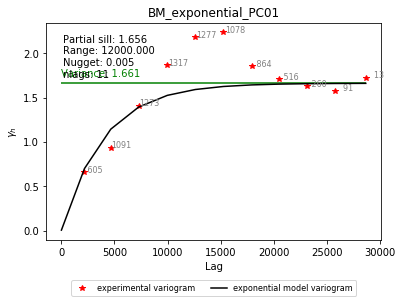

Calculating statistics on variogram model fit...
Q1 = 0.0336820366845894
Q2 = 1.295709649675495
cR = 0.886027876708963 

PC02
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.03982117712727819
Full Sill: 0.03993202119076361
Range: 12000
Nugget: 0.00011084406348542504 



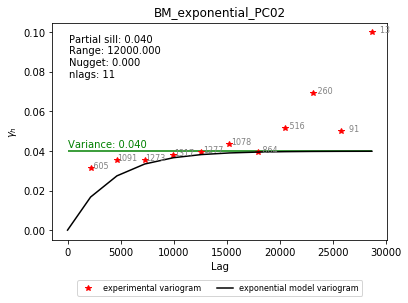

Calculating statistics on variogram model fit...
Q1 = 0.10126225313844797
Q2 = 2.60973866681349
cR = 0.04290462888900054 

PC03
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.007630161076223311
Full Sill: 0.00765139997772624
Range: 12000
Nugget: 2.1238901502928134e-05 



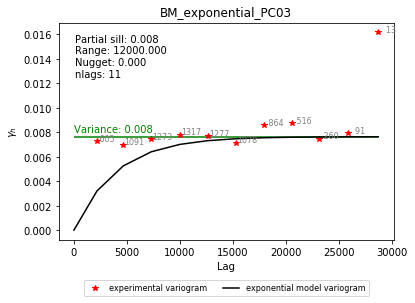

Calculating statistics on variogram model fit...
Q1 = 0.24397895920571303
Q2 = 3.372730998879664
cR = 0.010624498664056223 



In [33]:
X = coordinates_utm_BM.iloc[:, 0].values
Y = coordinates_utm_BM.iloc[:, 1].values

variograms_theoretical_BM = {}
i = 0
for component in mineralogy_pca_BM.columns.tolist()[:-1]:
    print(component)
    data = mineralogy_pca_BM.iloc[:, int(component[-1])-1].values
    variograms_theoretical_BM[component] = OrdinaryKriging(X, Y, data,
                                       variogram_model='exponential',
#                                        variogram_parameters={"scale": 0.00000019, "exponent": 2, "nugget":  nugget_replicates_BM[i]},
                                       variogram_parameters=variogram_model_parameters_theoretical_BM[component],
                                       nlags=n_lags_BM,
                                       verbose=True,
                                       enable_statistics=True,
                                       enable_plotting=True,
                                       weight=True,
                                       saveplot=True,
                                       coordinates_type='euclidean',
                                       saveloc="../_FIGURES/variograms/BM/",
                                       principal_component=component,
                                       pluton="BM_exponential")
    
    i += 1    
# NOTE that ideally Q1 is close to zero, Q2 is close to 1, and cR is as small as possible.

PC01
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.637926131292389
Full Sill: 1.6609396638593692
Range: 12000
Nugget: 0.023013532566980327 



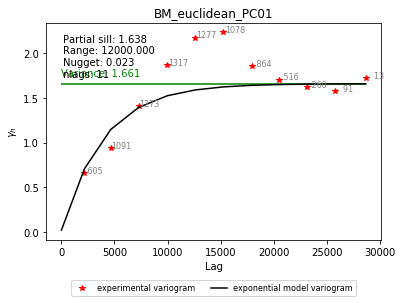

Calculating statistics on variogram model fit...
Q1 = 0.03445886194961435
Q2 = 1.256204871594707
cR = 0.8839051269105316 

PC02
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.0230450370553274
Full Sill: 0.03993202119076361
Range: 12000
Nugget: 0.01688698413543621 



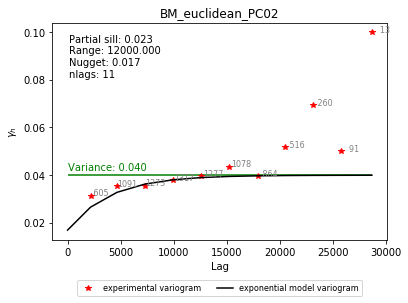

Calculating statistics on variogram model fit...
Q1 = 0.10212600417635558
Q2 = 1.2970810572803542
cR = 0.039467095700779775 

PC03
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.00494367933441931
Full Sill: 0.00765139997772624
Range: 12000
Nugget: 0.0027077206433069297 



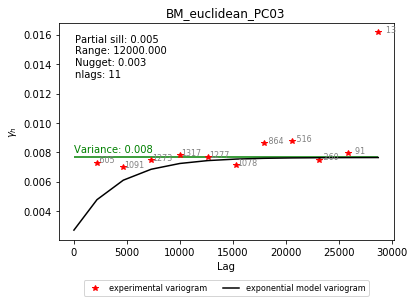

Calculating statistics on variogram model fit...
Q1 = 0.20933708835430528
Q2 = 1.5557600547835657
cR = 0.008500446947448073 



In [34]:
X = coordinates_utm_BM.iloc[:, 0].values
Y = coordinates_utm_BM.iloc[:, 1].values

variograms_replicates_BM = {}
i = 0
for component in mineralogy_pca_BM.columns.tolist()[:-1]:
    print(component)
    data = mineralogy_pca_BM.iloc[:, int(component[-1])-1].values
    variograms_replicates_BM[component] = OrdinaryKriging(X, Y, data,
                                       variogram_model='exponential',
#                                        variogram_parameters={"scale": 0.00000019, "exponent": 2, "nugget":  nugget_replicates_BM[i]},
                                       variogram_parameters=variogram_model_parameters_replicates_BM[component],
                                       nlags=n_lags_BM,
                                       verbose=True,
                                       enable_statistics=True,
                                       enable_plotting=True,
                                       weight=True,
                                       saveplot=True,
                                       coordinates_type='euclidean',
                                       saveloc="../_FIGURES/BM/",
                                       principal_component=component,
                                       pluton="BM_euclidean")
    
    i += 1    
# NOTE that ideally Q1 is close to zero, Q2 is close to 1, and cR is as small as possible.

## Leave One Out Cross Validation (LOOCV) of PCA

In [35]:
CV_results_theoretical_BM = preproc.load_obj("BM/CV_results_theoretical_BM")

In [36]:
CV_results_replicates_BM = preproc.load_obj("BM/CV_results_replicates_BM")

In [37]:
estimators_theoretical_BM = loocv.perform_loocv(mineralogy_pca_BM,
                                    coordinates_utm_BM,
                                    variogram_model_parameters_theoretical_BM,
                                    number_of_control_points_BM,
                                    n_lags=n_lags_BM,
                                    search_radii=[critical_distance_BM, range_BM[0], max_lag_distance_BM])

Fitting 130 folds for each of 6 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 765 out of 780 | elapsed:   24.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 130 folds for each of 6 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 130 folds for each of 6 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed:   12.6s finished


In [38]:
estimators_replicates_BM = loocv.perform_loocv(mineralogy_pca_BM,
                                    coordinates_utm_BM,
                                    variogram_model_parameters_replicates_BM,
                                    number_of_control_points_BM,
                                    n_lags=n_lags_BM,
                                    search_radii=[critical_distance_BM, range_BM[0], max_lag_distance_BM])

Fitting 130 folds for each of 6 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 130 folds for each of 6 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 130 folds for each of 6 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed:   13.8s finished


In [39]:
CV_results_theoretical_BM = loocv.convert_scores_to_df(estimators_theoretical_BM)

In [40]:
CV_results_replicates_BM = loocv.convert_scores_to_df(estimators_replicates_BM)

In [41]:
CV_results_theoretical_BM["PC01"]
CV_results_theoretical_BM["PC02"]
CV_results_theoretical_BM["PC03"]

rank_test_score  mean_test_score  std_test_score  mean_train_score  \
3                6         0.709705        1.227803      7.793207e-31   
5                5         0.720617        1.253990      1.359834e-30   
2                4         0.721597        1.314186      1.561972e-30   
4                3         0.747030        1.412694      2.571787e-30   
1                2         0.833244        1.607847      4.953327e-32   
0                1         0.838920        1.621060      0.000000e+00   

  param_method param_variogram_model param_search_radius  
3     ordinary           exponential               12000  
5     ordinary           exponential             30002.8  
2     ordinary             spherical               12000  
4     ordinary             spherical             30002.8  
1     ordinary           exponential                3800  
0     ordinary             spherical                3800

rank_test_score  mean_test_score  std_test_score  mean_train_score  \
5                6         0.036711        0.051342      1.230569e-33   
1                5         0.037097        0.053454      4.822905e-34   
0                4         0.037132        0.053669      0.000000e+00   
3                3         0.037181        0.051970      7.586477e-34   
4                2         0.037298        0.052498      0.000000e+00   
2                1         0.037619        0.053419      0.000000e+00   

  param_method param_variogram_model param_search_radius  
5     ordinary           exponential             30002.8  
1     ordinary           exponential                3800  
0     ordinary             spherical                3800  
3     ordinary           exponential               12000  
4     ordinary             spherical             30002.8  
2     ordinary             spherical               12000

rank_test_score  mean_test_score  std_test_score  mean_train_score  \
3                6         0.009022        0.013275      4.817097e-34   
5                5         0.009034        0.013300      4.645664e-34   
2                4         0.009297        0.013547      0.000000e+00   
1                3         0.009303        0.013547      2.653285e-34   
4                2         0.009321        0.013682      0.000000e+00   
0                1         0.009750        0.013965      0.000000e+00   

  param_method param_variogram_model param_search_radius  
3     ordinary           exponential               12000  
5     ordinary           exponential             30002.8  
2     ordinary             spherical               12000  
1     ordinary           exponential                3800  
4     ordinary             spherical             30002.8  
0     ordinary             spherical                3800

In [42]:
CV_results_replicates_BM["PC01"]
CV_results_replicates_BM["PC02"]
CV_results_replicates_BM["PC03"]

rank_test_score  mean_test_score  std_test_score  mean_train_score  \
3                6         0.710454        1.227610      6.054174e-31   
5                5         0.721100        1.252292      1.319308e-30   
2                4         0.722115        1.306868      1.372234e-30   
4                3         0.747236        1.402286      2.235578e-30   
1                2         0.834313        1.608192      4.008085e-32   
0                1         0.839539        1.619406      0.000000e+00   

  param_method param_variogram_model param_search_radius  
3     ordinary           exponential               12000  
5     ordinary           exponential             30002.8  
2     ordinary             spherical               12000  
4     ordinary             spherical             30002.8  
1     ordinary           exponential                3800  
0     ordinary             spherical                3800

rank_test_score  mean_test_score  std_test_score  mean_train_score  \
5                6         0.036468        0.049175      1.062636e-34   
3                5         0.036779        0.049403      1.316534e-34   
4                4         0.037799        0.050705      0.000000e+00   
2                3         0.037882        0.050796      0.000000e+00   
1                2         0.038700        0.056742      4.066313e-35   
0                1         0.039227        0.057466      0.000000e+00   

  param_method param_variogram_model param_search_radius  
5     ordinary           exponential             30002.8  
3     ordinary           exponential               12000  
4     ordinary             spherical             30002.8  
2     ordinary             spherical               12000  
1     ordinary           exponential                3800  
0     ordinary             spherical                3800

rank_test_score  mean_test_score  std_test_score  mean_train_score  \
4                6         0.007754        0.010590      0.000000e+00   
2                5         0.007778        0.010528      0.000000e+00   
3                4         0.007872        0.010915      2.136937e-35   
5                3         0.007888        0.010948      2.545584e-35   
0                2         0.008125        0.011236      0.000000e+00   
1                1         0.008194        0.011571      0.000000e+00   

  param_method param_variogram_model param_search_radius  
4     ordinary             spherical             30002.8  
2     ordinary             spherical               12000  
3     ordinary           exponential               12000  
5     ordinary           exponential             30002.8  
0     ordinary             spherical                3800  
1     ordinary           exponential                3800

In [45]:
preproc.save_obj(CV_results_theoretical_BM, "BM/CV_results_theoretical_BM")

In [46]:
preproc.save_obj(CV_results_replicates_BM, "BM/CV_results_replicates_BM")

In [47]:
loocv.print_best_scores(CV_results_theoretical_BM)

PC01
rank_test_score                    6
mean_test_score             0.709705
std_test_score                1.2278
mean_train_score         7.79321e-31
param_method                ordinary
param_variogram_model    exponential
param_search_radius            12000
Name: 3, dtype: object


PC02
rank_test_score                    6
mean_test_score            0.0367114
std_test_score             0.0513415
mean_train_score         1.23057e-33
param_method                ordinary
param_variogram_model    exponential
param_search_radius          30002.8
Name: 5, dtype: object


PC03
rank_test_score                    6
mean_test_score           0.00902155
std_test_score             0.0132751
mean_train_score          4.8171e-34
param_method                ordinary
param_variogram_model    exponential
param_search_radius            12000
Name: 3, dtype: object




In [48]:
loocv.print_best_scores(CV_results_replicates_BM)

PC01
rank_test_score                    6
mean_test_score             0.710265
std_test_score               1.22761
mean_train_score         6.90704e-31
param_method                ordinary
param_variogram_model    exponential
param_search_radius            12000
Name: 3, dtype: object


PC02
rank_test_score                    6
mean_test_score            0.0363644
std_test_score             0.0494637
mean_train_score         1.41302e-34
param_method                ordinary
param_variogram_model    exponential
param_search_radius          30002.8
Name: 5, dtype: object


PC03
rank_test_score                   6
mean_test_score          0.00785839
std_test_score            0.0108708
mean_train_score                  0
param_method               ordinary
param_variogram_model     spherical
param_search_radius         30002.8
Name: 4, dtype: object




## Calculating predictions for best model

In [37]:
estimators_final = {}

for component in ["PC01", "PC02", "PC03"]:
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            for variable_to_fit in ["estimates", "variances"]:
                
                estimators_final[f"{component}_{nugget}_{radius}_{variable_to_fit}"] = \
                    Krige(method='ordinary',
                          variogram_model="exponential",
                          variogram_model_parameters=variogram_model_parameters_BM[nugget][component],
                          nlags=n_lags_BM,
                          weight=True,
                          n_closest_points=number_of_control_points_BM,
                          search_radius=radius,
                          variable_to_fit=variable_to_fit)

In [38]:
kriging_predictions_BM = preproc.load_obj("BM/kriging_predictions_BM")

In [48]:
kriging_predictions_BM = {}

for component in ["PC01", "PC02", "PC03"]:
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            for variable_to_fit in ["estimates", "variances"]:
                kriging_predictions_BM[f"{component}_{nugget}_{radius}_{variable_to_fit}"] = \
                    cross_val_predict(estimators_final[f"{component}_{nugget}_{radius}_{variable_to_fit}"], 
                                      X=np.stack((coordinates_utm_BM["X"],
                                                  coordinates_utm_BM["Y"]), axis=1),
                                      y=mineralogy_pca_BM[component],
                                      cv=number_of_control_points_BM,
                                      n_jobs=-1,
                                      verbose=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  88 out of 130 | elapsed:    5.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of 130 | elapsed:    0.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n

In [49]:
preproc.save_obj(kriging_predictions_BM, "BM/kriging_predictions_BM")

## Calculate clr solutions

In [39]:
kriging_estimates_BM_df = {}

for nugget in ["theoretical", "replicates"]:
    for radius in [critical_distance_BM, range_BM[0]]:
        temp = {k:kriging_predictions_BM[k] for k in [f"PC01_{nugget}_{radius}_estimates", 
                                 f"PC02_{nugget}_{radius}_estimates", 
                                 f"PC03_{nugget}_{radius}_estimates"] if k in kriging_predictions_BM}
        
        kriging_estimates_BM_df[f"{nugget}_{radius}"] = pd.DataFrame.from_dict(temp)
        kriging_estimates_BM_df[f"{nugget}_{radius}"].index = mineralogy_pca_BM.index
        kriging_estimates_BM_df[f"{nugget}_{radius}"].columns = mineralogy_pca_BM.columns[:-1]
        print(f"{nugget}_{radius}")
        kriging_estimates_BM_df[f"{nugget}_{radius}"].head()

theoretical_3800


PC01      PC02      PC03
1    1.214124 -0.071246 -0.086486
105  1.203656 -0.038539 -0.041137
109  1.613082  0.090430 -0.088775
110  1.779025  0.095482 -0.004589
111 -0.873873 -0.239627 -0.017625

theoretical_12000


PC01      PC02      PC03
1    0.830820 -0.069030 -0.067486
105  1.230437 -0.034883 -0.036947
109  1.611600  0.090086 -0.087276
110  1.794258  0.093772 -0.003404
111 -0.868579 -0.230935 -0.018348

replicates_3800


PC01      PC02      PC03
1    1.247354 -0.062500 -0.086455
105  1.204730  0.000559 -0.039009
109  1.600462 -0.016660 -0.065473
110  1.740891 -0.064277 -0.033438
111 -0.855951 -0.096699 -0.029267

replicates_12000


PC01      PC02      PC03
1    0.850757 -0.060131 -0.048216
105  1.231074  0.010202 -0.034958
109  1.599272 -0.014020 -0.065657
110  1.757066 -0.048313 -0.028679
111 -0.851344 -0.100364 -0.028466

In [40]:
kriging_variances_BM_df = {}

for nugget in ["theoretical", "replicates"]:
    for radius in [critical_distance_BM, range_BM[0]]:
        temp = {k:kriging_predictions_BM[k] for k in [f"PC01_{nugget}_{radius}_variances", 
                                 f"PC02_{nugget}_{radius}_variances", 
                                 f"PC03_{nugget}_{radius}_variances"] if k in kriging_predictions_BM}
        
        kriging_variances_BM_df[f"{nugget}_{radius}"] = pd.DataFrame.from_dict(temp)
        kriging_variances_BM_df[f"{nugget}_{radius}"].index = mineralogy_pca_BM.index
        kriging_variances_BM_df[f"{nugget}_{radius}"].columns = mineralogy_pca_BM.columns[:-1]
        print(f"{nugget}_{radius}")
        kriging_variances_BM_df[f"{nugget}_{radius}"].head()

theoretical_3800


PC01      PC02      PC03
1    0.479833  0.011536  0.002210
105  0.365986  0.008799  0.001686
109  0.347126  0.008346  0.001599
110  0.415696  0.009994  0.001915
111  0.471964  0.011347  0.002174

theoretical_12000


PC01      PC02      PC03
1    0.441918  0.010625  0.002036
105  0.365453  0.008786  0.001684
109  0.347057  0.008344  0.001599
110  0.415361  0.009986  0.001913
111  0.471041  0.011325  0.002170

replicates_3800


PC01      PC02      PC03
1    0.508177  0.033190  0.005728
105  0.388498  0.025755  0.004463
109  0.369201  0.025315  0.004375
110  0.437108  0.025947  0.004527
111  0.491231  0.026458  0.004646

replicates_12000


PC01      PC02      PC03
1    0.467906  0.028581  0.005011
105  0.387934  0.025625  0.004447
109  0.369121  0.025242  0.004368
110  0.436756  0.025889  0.004521
111  0.490314  0.026426  0.004643

In [41]:
kriging_variances_mean_BM_df = {}

for nugget in ["theoretical", "replicates"]:
    for radius in [critical_distance_BM, range_BM[0]]:
        kriging_variances_mean_BM_df[f"{nugget}_{radius}"] = \
            kriging_variances_BM_df[f"{nugget}_{radius}"].mean(axis=0)
        
        print(f"{nugget}_{radius}")
        kriging_variances_mean_BM_df[f"{nugget}_{radius}"]

theoretical_3800


PC01    0.527201
PC02    0.012675
PC03    0.002429
dtype: float64

theoretical_12000


PC01    0.508568
PC02    0.012227
PC03    0.002343
dtype: float64

replicates_3800


PC01    0.546392
PC02    0.027867
PC03    0.004903
dtype: float64

replicates_12000


PC01    0.527462
PC02    0.026908
PC03    0.004744
dtype: float64

In [42]:
kriging_estimates_clr_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:

            kriging_estimates_clr_BM[f"{ncomp}_{nugget}_{radius}"] = \
                postproc.reverse_pca(pca_BM, 
                                     kriging_estimates_BM_df[f"{nugget}_{radius}"],
                                     mineralogy_clr_BM,
                                     n_comp=ncomp)

In [43]:
solutions_clr_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            
            solutions_clr_BM[f"{ncomp}_{nugget}_{radius}"] = \
                pd.DataFrame(kriging_estimates_clr_BM[f"{ncomp}_{nugget}_{radius}"], 
                             index=mineralogy_clr_BM.index, 
                             columns=["Q", "P", "K", "Others"])

In [44]:
residuals_clr_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            
            residuals_clr_BM[f"{ncomp}_{nugget}_{radius}"] = \
                mineralogy_clr_BM.subtract(solutions_clr_BM[f"{ncomp}_{nugget}_{radius}"])

In [58]:
for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            temp = pd.merge(residuals_clr_BM[f"{ncomp}_{nugget}_{radius}"], pd.DataFrame(nvalues_control_points_BM[radius], columns=["n_closest_points"]), left_index=True, right_index=True).sort_values("n_closest_points")
            temp.to_excel(f"../_RESULTS/BM/BM_residuals_clr_{ncomp}_{nugget}_{radius}.xlsx")

In [61]:
preproc.save_obj(residuals_clr_BM, "BM/residuals_clr_BM")

In [62]:
preproc.save_obj(nvalues_control_points_BM, "BM/nvalues_control_points_BM")

## Hotelling's one-sample T² test

Hotelling's one-sample T² test is performed in separate notebook since it runs in Python 2.7

## Calculate error budget

In [45]:
# A = mean squared prediction error
# B = nugget
# C = non-explained variance of model
error_budget_BM = {}

for nugget in ["theoretical", "replicates"]:
    for radius in [critical_distance_BM, range_BM[0]]:
        for ncomp in range(1, 4):
            A = np.mean(np.sum(residuals_clr_BM[f"{ncomp}_{nugget}_{radius}"] ** 2, axis=1), axis=0)
            if nugget == "theoretical":
                B = nugget_theoretical_BM[:ncomp].sum()
            else:
                B = nugget_replicates_BM[:ncomp].sum()

            C = A - B

            error_budget_BM[f"{ncomp}_{nugget}_{radius}"] = [A, B, C]

In [46]:
error_budget_df_BM = \
    ttest.convert_summary_test_results_to_df(error_budget_BM, 
                                             variable_names=["MSPE", "Nugget", "Non-expl var of model"], 
                                             order=["nugget_type", "search_radius", "#PCs"])
error_budget_df_BM

nugget_type  search_radius  #PCs      MSPE    Nugget  \
0    replicates           3800     1  0.881531  0.023014   
1    replicates           3800     2  0.880606  0.039901   
2    replicates           3800     3  0.881207  0.042608   
3    replicates          12000     1  0.757671  0.023014   
4    replicates          12000     2  0.754825  0.039901   
5    replicates          12000     3  0.755105  0.042608   
6   theoretical           3800     1  0.880461  0.004610   
7   theoretical           3800     2  0.877933  0.004721   
8   theoretical           3800     3  0.879644  0.004743   
9   theoretical          12000     1  0.756922  0.004610   
10  theoretical          12000     2  0.754478  0.004721   
11  theoretical          12000     3  0.755907  0.004743   

    Non-expl var of model  
0                0.858517  
1                0.840705  
2                0.838599  
3                0.734658  
4                0.714925  
5                0.712496  
6                0.875851  
7                0.873212  
8                0.874901  
9                0.752311  
10               0.749757  
11               0.751165

In [63]:
error_budget_df_BM.to_excel("../_RESULTS/Error_budget/BM_error_budget.xlsx")

___

## Cross variograms t-tests residuals

In [47]:
residuals_pca_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            residuals_pca_BM[f"{ncomp}_{nugget}_{radius}"] = \
                preproc.pca(residuals_clr_BM[f"{ncomp}_{nugget}_{radius}"])

In [50]:
preproc.save_obj(residuals_pca_BM, "BM/residuals_pca_BM")

In [48]:
residuals_pca_df_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            residuals_pca_df_BM[f"{ncomp}_{nugget}_{radius}"] = \
                preproc.create_pca_df(residuals_pca_BM[f"{ncomp}_{nugget}_{radius}"], 
                                      residuals_clr_BM[f"{ncomp}_{nugget}_{radius}"])

In [66]:
cross_variogram_results_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            cross_variogram_results_BM[f"{ncomp}_{nugget}_{radius}"] = \
                krigingtools.calculate_variogram_results(residuals_pca_df_BM[f"{ncomp}_{nugget}_{radius}"], 
                                                         coordinates_utm_BM,
                                                         n_lags=n_lags_BM,
                                                         lags_threshold=radius)

In [67]:
ttest_results_residuals_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            ttest_results_residuals_BM[f"{ncomp}_{nugget}_{radius}"] = \
                ttest.perform_ttest(cross_variogram_results_BM[f"{ncomp}_{nugget}_{radius}"])

In [68]:
ttest_residuals_df_dict_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            ttest_residuals_df_dict_BM[f"{ncomp}_{nugget}_{radius}"] = \
                ttest.convert_ttest_results_to_dict_of_df(ttest_results_residuals_BM[f"{ncomp}_{nugget}_{radius}"])

In [69]:
ttest_crit_BM = {}
for radius in [critical_distance_BM, range_BM[0]]:
    ttest_crit_BM[radius] = t.isf(0.05, df=cross_variogram_results_BM[f"1_replicates_{radius}"]["PC01PC02"][3][0].shape[0] - 1)
ttest_crit_BM

{3800: 1.663883912866253, 12000: 1.6481584922974342}

In [70]:
ttest_summary_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:

            ttest_results = []
            PC_expl_var_sum = []
            for i in range(ttest_residuals_df_dict_BM[f"{ncomp}_{nugget}_{radius}"]["PC01PC02"].shape[0] - 1):
                ttest_result = []
                for PCx, PCy in combinations(["PC01", "PC02", "PC03"], 2):
                    ttest_result.append(ttest_residuals_df_dict_BM[f"{ncomp}_{nugget}_{radius}"][PCx+PCy].iloc[i, 0])
                ttest_results.append(np.array(ttest_result))
                
            for PCx, PCy in combinations(["PC01", "PC02", "PC03"], 2):
                PC_expl_var = residuals_pca_BM[f"{ncomp}_{nugget}_{radius}"].explained_variance_ratio_[:-1]
                PC_expl_var_sum.append(PC_expl_var[int(PCx[-1]) - 1] + PC_expl_var[int(PCy[-1]) - 1])
                
            # print(ttest_results)
            PC_expl_var_sum_array = np.array(PC_expl_var_sum)
#             print(PC_expl_var_sum_array)
            ttest_results_array = np.array(ttest_results)
#             print(ttest_results_array)
            ttest_summary = np.mean(np.dot(abs(ttest_results_array), PC_expl_var_sum_array))
            ttest_summary_BM[f"{ncomp}_{nugget}_{radius}"] = [ttest_summary, ttest_crit_BM[radius], abs(ttest_summary) > ttest_crit_BM[radius]]

In [71]:
ttest_summary_df_BM = ttest.convert_summary_test_results_to_df(ttest_summary_BM)
ttest_summary_df_BM

#PCs  nugget_type  search_radius  ttest_stat  ttest_crit  abs(stat) > crit
0      1   replicates           3800    1.714870    1.663884              True
1      1   replicates          12000    1.433433    1.648158             False
2      1  theoretical           3800    1.718390    1.663884              True
3      1  theoretical          12000    1.426970    1.648158             False
4      2   replicates           3800    1.761219    1.663884              True
5      2   replicates          12000    1.808914    1.648158              True
6      2  theoretical           3800    1.667217    1.663884              True
7      2  theoretical          12000    2.013603    1.648158              True
8      3   replicates           3800    1.742150    1.663884              True
9      3   replicates          12000    1.792263    1.648158              True
10     3  theoretical           3800    1.700663    1.663884              True
11     3  theoretical          12000    1.997896    1.648158              True

In [72]:
ttest_summary_df_BM.to_excel("../_RESULTS/ttests/BM_overall_ttest_DoF_bin_size.xlsx")

In [73]:
ttest_crit_DoF_number_of_bins_BM = t.isf(0.05, df=n_lags_BM-1-1)
ttest_crit_DoF_number_of_bins_BM

1.8331129326536337

In [74]:
ttest_summary_BM_new = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:

            ttest_results = []
            PC_expl_var_sum = []
            for i in range(ttest_residuals_df_dict_BM[f"{ncomp}_{nugget}_{radius}"]["PC01PC02"].shape[0] - 1):
                ttest_result = []
                for PCx, PCy in combinations(["PC01", "PC02", "PC03"], 2):
                    ttest_result.append(ttest_residuals_df_dict_BM[f"{ncomp}_{nugget}_{radius}"][PCx+PCy].iloc[i, 0])
                ttest_results.append(np.array(ttest_result))
                
            for PCx, PCy in combinations(["PC01", "PC02", "PC03"], 2):
                PC_expl_var = residuals_pca_BM[f"{ncomp}_{nugget}_{radius}"].explained_variance_ratio_[:-1]
                PC_expl_var_sum.append(PC_expl_var[int(PCx[-1]) - 1] + PC_expl_var[int(PCy[-1]) - 1])
                
            # print(ttest_results)
            PC_expl_var_sum_array = np.array(PC_expl_var_sum)
#             print(PC_expl_var_sum_array)
            ttest_results_array = np.array(ttest_results)
#             print(ttest_results_array)
            ttest_summary = np.mean(np.dot(abs(ttest_results_array), PC_expl_var_sum_array))
            ttest_summary_BM_new[f"{ncomp}_{nugget}_{radius}"] = [ttest_summary, ttest_crit_DoF_number_of_bins_BM, abs(ttest_summary) > ttest_crit_DoF_number_of_bins_BM]

In [75]:
ttest_summary_df_BM_new = ttest.convert_summary_test_results_to_df(ttest_summary_BM_new)
ttest_summary_df_BM_new

KeyError: 'ttest_stat'

In [ ]:
ttest_summary_df_BM.to_excel("../_RESULTS/ttests/BM_overall_ttest_DoF_number_of_bins.xlsx")

## Cross variograms t-tests control points

In [75]:
components = ["PC01", "PC02", "PC03"]

In [76]:
pca_original_ncomp_BM = {}

for ncomp in [2, 3]:
    pca_original_ncomp_BM[ncomp] = mineralogy_pca_BM.iloc[:, :ncomp]

In [77]:
cross_variogram_results_original_BM = {}

for ncomp in [2, 3]:
    cross_variogram_results_original_BM[ncomp] = \
        krigingtools.calculate_variogram_results(pca_original_ncomp_BM[ncomp], 
                                                 coordinates_utm_BM,
                                                 n_lags=n_lags_BM,
                                                 lags_threshold=range_BM[0],
                                                 components=components[:ncomp])

In [78]:
ttest_results_residuals_original_BM = {}

for ncomp in [2, 3]:
    ttest_results_residuals_original_BM[ncomp] = \
        ttest.perform_ttest(cross_variogram_results_original_BM[ncomp])

In [79]:
ttest_residuals_df_dict_original_BM = {}

for ncomp in [2, 3]:
    ttest_residuals_df_dict_original_BM[ncomp] = \
        ttest.convert_ttest_results_to_dict_of_df(ttest_results_residuals_original_BM[ncomp])

In [80]:
ttest_crit_original_BM = t.isf(0.05, df=cross_variogram_results_original_BM[2]["PC01PC02"][3][0].shape[0] - 1)
ttest_crit_original_BM

1.6481584922974342

In [81]:
ttest_summary_original_BM = {}

for ncomp in [2, 3]:

    ttest_results = []
    PC_expl_var_sum = []
    for i in range(ttest_residuals_df_dict_original_BM[ncomp]["PC01PC02"].shape[0] - 1):
        ttest_result = []
        for PCx, PCy in combinations(components[:ncomp], 2):
            ttest_result.append(ttest_residuals_df_dict_original_BM[ncomp][PCx+PCy].iloc[i, 0])
        ttest_results.append(np.array(ttest_result))

    for PCx, PCy in combinations(components[:ncomp], 2):
        PC_expl_var = pca_BM.explained_variance_ratio_[:ncomp]
        PC_expl_var_sum.append(PC_expl_var[int(PCx[-1]) - 1] + PC_expl_var[int(PCy[-1]) - 1])

    # print(ttest_results)
    PC_expl_var_sum_array = np.array(PC_expl_var_sum)
#             print(PC_expl_var_sum_array)
    ttest_results_array = np.array(ttest_results)
#             print(ttest_results_array)
    ttest_summary = np.mean(np.dot(abs(ttest_results_array), PC_expl_var_sum_array))
    ttest_summary_original_BM[ncomp] = [ttest_summary, ttest_crit_original_BM, abs(ttest_summary) > ttest_crit_original_BM]

In [82]:
ttest_summary_original_df_BM = ttest.convert_summary_test_results_to_df_original(ttest_summary_original_BM)
ttest_summary_original_df_BM

#PCs  ttest_stat  ttest_crit  abs(stat) > crit
0     2    2.247346    1.648158              True
1     3    3.918779    1.648158              True

## Empirical statistical tests residuals

In [83]:
selected_model = "2_replicates_12000"

In [84]:
n_runs = {}

for key in residuals_clr_BM.keys():
#     if key == selected_model:
#         n_runs[key] = 1000
#     else:
    n_runs[key] = 1000

In [85]:
n_runs

{'1_theoretical_3800': 1000,
 '1_theoretical_12000': 1000,
 '1_replicates_3800': 1000,
 '1_replicates_12000': 1000,
 '2_theoretical_3800': 1000,
 '2_theoretical_12000': 1000,
 '2_replicates_3800': 1000,
 '2_replicates_12000': 1000,
 '3_theoretical_3800': 1000,
 '3_theoretical_12000': 1000,
 '3_replicates_3800': 1000,
 '3_replicates_12000': 1000}

In [86]:
%%time
sample_residuals_clr_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            samples_random_gens = []
            for i in range(n_runs[f"{ncomp}_{nugget}_{radius}"]):
                samples_random_gens.append(residuals_clr_BM[f"{ncomp}_{nugget}_{radius}"].sample(n=number_of_control_points_BM, random_state=i).reset_index(drop=True))
            sample_residuals_clr_BM[f"{ncomp}_{nugget}_{radius}"] = samples_random_gens

Wall time: 5.06 s


In [87]:
sample_residuals_clr_BM["2_replicates_12000"][0].shape

(130, 4)

In [88]:
%%time
sample_residuals_pca_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            sample_random_pca = []
            for i in range(n_runs[f"{ncomp}_{nugget}_{radius}"]):
                sample_random_pca.append(preproc.pca(sample_residuals_clr_BM[f"{ncomp}_{nugget}_{radius}"][i]))
            sample_residuals_pca_BM[f"{ncomp}_{nugget}_{radius}"] = sample_random_pca

Wall time: 10.3 s


In [89]:
%%time
sample_residuals_pca_df_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            sample_random_pca_df = []
            for i in range(n_runs[f"{ncomp}_{nugget}_{radius}"]):
                sample_random_pca_df.append(preproc.create_pca_df(sample_residuals_pca_BM[f"{ncomp}_{nugget}_{radius}"][i], 
                                                                  sample_residuals_clr_BM[f"{ncomp}_{nugget}_{radius}"][i]))
            sample_residuals_pca_df_BM[f"{ncomp}_{nugget}_{radius}"] = sample_random_pca_df

Wall time: 7.7 s


In [48]:
sample_cross_variogram_results_BM = preproc.load_obj("BM/sample_cross_variogram_results_BM")

In [90]:
%%time
sample_cross_variogram_results_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            sample_random_cross_variogram_results = Parallel(n_jobs=-1)(delayed(krigingtools.calculate_variogram_results)(
                sample_residuals_pca_df_BM[f"{ncomp}_{nugget}_{radius}"][i], 
                                                         coordinates_utm_BM,
                                                         n_lags=n_lags_BM,
                                                         lags_threshold=radius) for i in range(n_runs[f"{ncomp}_{nugget}_{radius}"]))
            sample_cross_variogram_results_BM[f"{ncomp}_{nugget}_{radius}"] = sample_random_cross_variogram_results
            print(f"{ncomp}_{nugget}_{radius}", "OK")

1_theoretical_3800 OK
1_theoretical_12000 OK
1_replicates_3800 OK
1_replicates_12000 OK
2_theoretical_3800 OK
2_theoretical_12000 OK
2_replicates_3800 OK
2_replicates_12000 OK
3_theoretical_3800 OK
3_theoretical_12000 OK
3_replicates_3800 OK
3_replicates_12000 OK
Wall time: 4min 15s


In [92]:
preproc.save_obj(sample_cross_variogram_results_BM, "BM/sample_cross_variogram_results_BM")

In [93]:
%%time
sample_ttest_results_residuals_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            sample_random_ttest_results_residuals = Parallel(n_jobs=-1)(delayed(ttest.perform_ttest)(
                sample_cross_variogram_results_BM[f"{ncomp}_{nugget}_{radius}"][i]) for i in range(n_runs[f"{ncomp}_{nugget}_{radius}"]))
            sample_ttest_results_residuals_BM[f"{ncomp}_{nugget}_{radius}"] = sample_random_ttest_results_residuals
            print(f"{ncomp}_{nugget}_{radius}", "OK")

1_theoretical_3800 OK
1_theoretical_12000 OK
1_replicates_3800 OK
1_replicates_12000 OK
2_theoretical_3800 OK
2_theoretical_12000 OK
2_replicates_3800 OK
2_replicates_12000 OK
3_theoretical_3800 OK
3_theoretical_12000 OK
3_replicates_3800 OK
3_replicates_12000 OK
Wall time: 1min 41s


In [94]:
%%time
sample_ttest_residuals_df_dict_BM = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            sample_random_ttest_residuals_df_dict = []
            for i in range(n_runs[f"{ncomp}_{nugget}_{radius}"]):
                sample_random_ttest_residuals_df_dict.append(ttest.convert_ttest_results_to_dict_of_df(sample_ttest_results_residuals_BM[f"{ncomp}_{nugget}_{radius}"][i]))
            sample_ttest_residuals_df_dict_BM[f"{ncomp}_{nugget}_{radius}"] = sample_random_ttest_residuals_df_dict
            print(f"{ncomp}_{nugget}_{radius}", "OK")

1_theoretical_3800 OK
1_theoretical_12000 OK
1_replicates_3800 OK
1_replicates_12000 OK
2_theoretical_3800 OK
2_theoretical_12000 OK
2_replicates_3800 OK
2_replicates_12000 OK
3_theoretical_3800 OK
3_theoretical_12000 OK
3_replicates_3800 OK
3_replicates_12000 OK
Wall time: 25.3 s


In [95]:
%%time
sample_ttest_summary_BM = {}

for ncomp in range(1, 4):
    for nugget in ["replicates", "theoretical"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            
            sample_ttest_summary = []
            for j in range(n_runs[f"{ncomp}_{nugget}_{radius}"]):

                ttest_results = []
                PC_expl_var_sum = []
                for i in range(sample_ttest_residuals_df_dict_BM[f"{ncomp}_{nugget}_{radius}"][j]["PC01PC02"].shape[0] - 1):
                    ttest_result = []
                    for PCx, PCy in combinations(["PC01", "PC02", "PC03"], 2):
                        ttest_result.append(sample_ttest_residuals_df_dict_BM[f"{ncomp}_{nugget}_{radius}"][j][PCx+PCy].iloc[i, 0])
                    ttest_results.append(np.array(ttest_result))

                for PCx, PCy in combinations(["PC01", "PC02", "PC03"], 2):
                    PC_expl_var = sample_residuals_pca_BM[f"{ncomp}_{nugget}_{radius}"][j].explained_variance_ratio_[:-1]
                    PC_expl_var_sum.append(PC_expl_var[int(PCx[-1]) - 1] + PC_expl_var[int(PCy[-1]) - 1])

                PC_expl_var_sum_array = np.array(PC_expl_var_sum)
                ttest_results_array = np.array(ttest_results)
                # Divide by 2? --> NO
                ttest_summary = np.mean(np.dot(np.abs(ttest_results_array), PC_expl_var_sum_array))
                
                if (j == 1) & (ncomp == 2) & (nugget == "replicates") & (radius == range_BM[0]):
                    print(PC_expl_var)
                    print(PC_expl_var_sum_array)
                    print(ttest_results_array)
                    print(np.dot(abs(ttest_results_array), PC_expl_var_sum_array))
                    print(ttest_summary)
                
                sample_ttest_summary.append(ttest_summary)
            
            sample_ttest_summary_BM[f"{ncomp}_{nugget}_{radius}"] = sample_ttest_summary
            print(f"{ncomp}_{nugget}_{radius}", "OK")

1_replicates_3800 OK
1_replicates_12000 OK
1_theoretical_3800 OK
1_theoretical_12000 OK
2_replicates_3800 OK
[0.94172959 0.04833926 0.00993115]
[0.99006885 0.95166074 0.05827041]
[[ 0.61641867 -1.07866645 -0.09122009]
 [ 1.32630496  0.77459267 -2.07954339]
 [-1.67636887 -0.40445159  0.07678343]
 [-1.62593131  3.01918229  1.72745797]
 [-0.69292452  0.01168961 -1.06365558]
 [-0.89429626 -0.9800679   0.75833145]
 [-0.05952688  0.52884218 -0.38143368]
 [-1.91974445  1.21594087 -0.77581499]
 [-0.93513663 -0.95905037  1.18549999]
 [-0.4408663  -0.30720776 -0.79012097]]
[1.64213687 2.1714585  2.04909551 4.58368088 0.75914718 1.8622953
 0.58444035 3.10304942 1.90761981 0.77488623]
1.9437810033615022
2_replicates_12000 OK
2_theoretical_3800 OK
2_theoretical_12000 OK
3_replicates_3800 OK
3_replicates_12000 OK
3_theoretical_3800 OK
3_theoretical_12000 OK
Wall time: 8.46 s


In [96]:
empirical_thresholds = {}

for ncomp in range(1, 4):
    for nugget in ["theoretical", "replicates"]:
        for radius in [critical_distance_BM, range_BM[0]]:
            empirical_thresholds[f"{ncomp}_{nugget}_{radius}"] = np.percentile(sample_ttest_summary_BM[f"{ncomp}_{nugget}_{radius}"], 95)

In [97]:
empirical_thresholds_df = pd.DataFrame.from_dict(empirical_thresholds, orient='index')
empirical_thresholds_df

0
1_theoretical_3800   2.132303
1_theoretical_12000  2.545383
1_replicates_3800    2.134102
1_replicates_12000   2.551085
2_theoretical_3800   2.119138
2_theoretical_12000  2.616866
2_replicates_3800    2.106287
2_replicates_12000   2.597956
3_theoretical_3800   2.140973
3_theoretical_12000  2.615348
3_replicates_3800    2.133149
3_replicates_12000   2.617705

In [101]:
sample_ttest_summary_df_BM = ttest_summary_df_BM.copy()
sample_ttest_summary_df_BM["ttest_crit"] = empirical_thresholds_df[0].values
sample_ttest_summary_df_BM["abs(stat) > crit"] = np.abs(sample_ttest_summary_df_BM["ttest_stat"]) > sample_ttest_summary_df_BM["ttest_crit"]
sample_ttest_summary_df_BM = sample_ttest_summary_df_BM.rename(columns = {"ttest_stat": "test_stat", "ttest_crit": "test_crit", })
sample_ttest_summary_df_BM["n_runs"] = [value for value in n_runs.values()]
sample_ttest_summary_df_BM

#PCs  nugget_type  search_radius  test_stat  test_crit  abs(stat) > crit  \
0      1   replicates           3800   1.714870   2.132303             False   
1      1   replicates          12000   1.433433   2.545383             False   
2      1  theoretical           3800   1.718390   2.134102             False   
3      1  theoretical          12000   1.426970   2.551085             False   
4      2   replicates           3800   1.761219   2.119138             False   
5      2   replicates          12000   1.808914   2.616866             False   
6      2  theoretical           3800   1.667217   2.106287             False   
7      2  theoretical          12000   2.013603   2.597956             False   
8      3   replicates           3800   1.742150   2.140973             False   
9      3   replicates          12000   1.792263   2.615348             False   
10     3  theoretical           3800   1.700663   2.133149             False   
11     3  theoretical          12000   1.997896   2.617705             False   

    n_runs  
0     1000  
1     1000  
2     1000  
3     1000  
4     1000  
5     1000  
6     1000  
7     1000  
8     1000  
9     1000  
10    1000  
11    1000

In [108]:
sample_ttest_summary_df_BM.to_excel("../_RESULTS/empirical_tests/BM_overall_empirical_test_1000_new.xlsx")

In [102]:
# reformat = pd.read_clipboard()
reformat = sample_ttest_summary_df_BM.copy()

In [103]:
reformat = reformat.sort_values(["nugget_type", "search_radius", "#PCs"])

In [104]:
reformat = reformat[["nugget_type", "search_radius", "#PCs", "test_stat", "test_crit", "abs(stat) > crit"]].reset_index(drop=True)

In [105]:
reformat["ratio"] = np.abs(reformat["test_stat"]) / reformat["test_crit"]

In [106]:
reformat

nugget_type  search_radius  #PCs  test_stat  test_crit  abs(stat) > crit  \
0    replicates           3800     1   1.714870   2.132303             False   
1    replicates           3800     2   1.761219   2.119138             False   
2    replicates           3800     3   1.742150   2.140973             False   
3    replicates          12000     1   1.433433   2.545383             False   
4    replicates          12000     2   1.808914   2.616866             False   
5    replicates          12000     3   1.792263   2.615348             False   
6   theoretical           3800     1   1.718390   2.134102             False   
7   theoretical           3800     2   1.667217   2.106287             False   
8   theoretical           3800     3   1.700663   2.133149             False   
9   theoretical          12000     1   1.426970   2.551085             False   
10  theoretical          12000     2   2.013603   2.597956             False   
11  theoretical          12000     3   1.997896   2.617705             False   

       ratio  
0   0.804234  
1   0.831101  
2   0.813719  
3   0.563150  
4   0.691252  
5   0.685287  
6   0.805205  
7   0.791543  
8   0.797255  
9   0.559358  
10  0.775072  
11  0.763224

In [107]:
reformat.to_excel("../_RESULTS/empirical_tests/BM_overall_empirical_test_1000_reformat_new.xlsx")

In [109]:
# Free up working memory
del sample_cross_variogram_results_BM

## Empirical statistical tests control points

In [110]:
nruns = 1000

In [111]:
pca_original_ncomp_BM = {}

for ncomp in [2, 3]:
    pca_original_ncomp_BM[ncomp] = mineralogy_pca_BM.iloc[:, :ncomp]

In [112]:
%%time
sample_pca_original_BM = {}

for ncomp in [2, 3]:
    sample_pca_original = []
    for i in range(nruns):
        sample_pca_original.append(pca_original_ncomp_BM[ncomp].sample(n=number_of_control_points_BM, random_state=i).reset_index(drop=True))
    sample_pca_original_BM[ncomp] = sample_pca_original

Wall time: 917 ms


In [113]:
sample_pca_original_BM[2][0].shape
sample_pca_original_BM[3][0].shape

(130, 2)

(130, 3)

In [114]:
# You need to determine the range before the next step

In [115]:
components = ["PC01", "PC02", "PC03"]

In [116]:
%%time
sample_cross_variogram_results_original_BM = {}

for ncomp in [2, 3]:
    sample_cross_variogram_results_original = Parallel(n_jobs=-1)(delayed(krigingtools.calculate_variogram_results)(
         sample_pca_original_BM[ncomp][i], 
         coordinates_utm_BM,
         n_lags=n_lags_BM,
         lags_threshold=range_BM[0],
         components=components[:ncomp]) for i in range(nruns))
    
    sample_cross_variogram_results_original_BM[ncomp] = sample_cross_variogram_results_original

Wall time: 35.3 s


In [117]:
%%time
sample_ttest_results_original_BM = {}

for ncomp in [2, 3]:
    sample_ttest_results_original = Parallel(n_jobs=-1)(delayed(ttest.perform_ttest)(
        sample_cross_variogram_results_original_BM[ncomp][i]) for i in range(nruns))
    sample_ttest_results_original_BM[ncomp] = sample_ttest_results_original

Wall time: 11.9 s


In [118]:
%%time
sample_ttest_df_dict_original_BM = {}

for ncomp in [2, 3]:
    sample_ttest_df_dict_original = []
    for i in range(nruns):
        sample_ttest_df_dict_original.append(ttest.convert_ttest_results_to_dict_of_df(sample_ttest_results_original_BM[ncomp][i]))
    sample_ttest_df_dict_original_BM[ncomp] = sample_ttest_df_dict_original

Wall time: 2.53 s


In [119]:
%%time
sample_ttest_summary_original_BM = {}

for ncomp in [2, 3]:
    sample_ttest_summary_original = []
    for j in range(nruns):

        ttest_results = []
        PC_expl_var_sum = []

        for i in range(sample_ttest_df_dict_original_BM[ncomp][j]["PC01PC02"].shape[0] - 1):
            ttest_result = []
            for PCx, PCy in combinations(components[:ncomp], 2):
                ttest_result.append(sample_ttest_df_dict_original_BM[ncomp][j][PCx+PCy].iloc[i, 0])
            ttest_results.append(np.array(ttest_result))

        for PCx, PCy in combinations(components[:ncomp], 2):
            PC_expl_var = pca_BM.explained_variance_ratio_[:ncomp]
            PC_expl_var_sum.append(PC_expl_var[int(PCx[-1]) - 1] + PC_expl_var[int(PCy[-1]) - 1])

        PC_expl_var_sum_array = np.array(PC_expl_var_sum)
        ttest_results_array = np.array(ttest_results)
        # Divide by 2? --> NO
        ttest_summary = np.mean(np.dot(np.abs(ttest_results_array), PC_expl_var_sum_array))

        if (j == 1) & (ncomp == 2):
            print(PC_expl_var)
            print(PC_expl_var_sum_array)
            print(ttest_results_array)
            print(np.dot(abs(ttest_results_array), PC_expl_var_sum_array))
            print(ttest_summary)

        sample_ttest_summary_original.append(ttest_summary)
    print(ncomp)
    sample_ttest_summary_original_BM[ncomp] = sample_ttest_summary_original

[0.97214938 0.02337225]
[0.99552163]
[[ 1.71426513]
 [-0.2745227 ]
 [ 0.9615854 ]
 [ 1.7141774 ]
 [ 1.11643768]
 [ 2.3067945 ]
 [ 0.51675275]
 [ 1.94801324]
 [ 1.75321523]
 [ 0.73860661]]
[1.70658801 0.27329329 0.95727906 1.70650068 1.11143786 2.29646382
 0.51443854 1.93928931 1.74536368 0.73529885]
1.2985953123879725
2
3
Wall time: 4.66 s


In [120]:
%%time
empirical_thresholds_original = {}

for ncomp in [2, 3]:
    empirical_thresholds_original[ncomp] = np.percentile(sample_ttest_summary_original_BM[ncomp], 95)

Wall time: 1e+03 µs


In [121]:
empirical_thresholds_original_df = pd.DataFrame.from_dict(empirical_thresholds_original, orient='index')
empirical_thresholds_original_df

0
2  1.425608
3  2.535359

In [122]:
sample_ttest_summary_df_original_BM = ttest_summary_original_df_BM.copy()
sample_ttest_summary_df_original_BM["ttest_crit"] = empirical_thresholds_original_df[0].values
sample_ttest_summary_df_original_BM["abs(stat) > crit"] = np.abs(sample_ttest_summary_df_original_BM["ttest_stat"]) > sample_ttest_summary_df_original_BM["ttest_crit"]
sample_ttest_summary_df_original_BM = sample_ttest_summary_df_original_BM.rename(columns = {"ttest_stat": "test_stat", "ttest_crit": "test_crit", })
sample_ttest_summary_df_original_BM["n_runs"] = nruns
sample_ttest_summary_df_original_BM

#PCs  test_stat  test_crit  abs(stat) > crit  n_runs
0     2   2.247346   1.425608              True    1000
1     3   3.918779   2.535359              True    1000

In [123]:
sample_ttest_summary_df_original_BM.to_excel("../_RESULTS/empirical_tests_original/BM_overall_empirical_test_1000_original_new.xlsx")

## Contour plots replicates' nugget

In [49]:
nvalues_critical_distance_BM = variograms_replicates_BM["PC01"].determine_mask_array(grid_wide_BM[0], grid_wide_BM[1], search_radius=critical_distance_BM)
mask_critical_distance_BM = nvalues_critical_distance_BM < 3
mask_critical_distance_BM.shape

(130, 2)
(270039, 2)
539 501


(501, 539)

In [50]:
mask_critical_distance_BM[mask_critical_distance_BM == 1].sum()

150989

In [51]:
non_masked_grid_nodes = grid_wide_BM[0].shape[0] * grid_wide_BM[1].shape[0] - mask_critical_distance_BM[mask_critical_distance_BM == 1].sum()

In [52]:
grid_cell_spacing = grid_wide_BM[0][1] - grid_wide_BM[0][0]
grid_cell_area = grid_cell_spacing ** 2

In [53]:
# Pluton area in m²
pluton_area_m2 = non_masked_grid_nodes * grid_cell_area

# Pluton area in km²
pluton_area_km2 = pluton_area_m2 / 1_000_000

In [54]:
pluton_area_km2

575.5182320448455

In [55]:
interpolated_replicates_12000_BM_dict = preproc.load_obj("BM/interpolated_replicates_12000_wide_BM_dict")

In [126]:
%%time
interpolated_replicates_12000_BM_parallel = Parallel(n_jobs=3)(delayed(
    OK_model.execute)('masked', 
                     grid_wide_BM[0], 
                     grid_wide_BM[1],
                     mask_critical_distance_BM,
                     n_closest_points=number_of_control_points_BM, 
                     search_radius=range_BM[0], 
                     backend='loop') for component, OK_model in variograms_replicates_BM.items())

Wall time: 52.3 s


In [127]:
interpolated_replicates_12000_BM_dict = {}
for i, item in enumerate(interpolated_replicates_12000_BM_parallel, start=1):
    interpolated_replicates_12000_BM_dict[f"PC0{i}"] = item

In [128]:
preproc.save_obj(interpolated_replicates_12000_BM_dict, "BM/interpolated_replicates_12000_wide_BM_dict")

In [56]:
interpolated_replicates_12000_BM_array = postproc.convert_grid_to_array_of_scores(interpolated_replicates_12000_BM_dict)
interpolated_reverse_pca_BM = postproc.reverse_pca(pca_BM, interpolated_replicates_12000_BM_array, mineralogy_clr_BM, n_comp=2)
interpolated_reverse_clr_BM = postproc.reverse_clr(interpolated_reverse_pca_BM, mineralogy_clr_BM)

1
2
3
(3, 501, 539)


C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
assert grid_wide_BM[0].shape[0] * grid_wide_BM[1].shape[0] == np.sum(np.isclose(interpolated_reverse_clr_BM.sum(axis=1), 0.0)) + \
                                                              np.sum(np.isclose(interpolated_reverse_clr_BM.sum(axis=1), 100.0))

In [58]:
interpolated_modal_BM = {}
for mineral in interpolated_reverse_clr_BM.columns.tolist():
    interpolated_modal_BM[mineral] = np.reshape(interpolated_reverse_clr_BM.loc[:, mineral].values, (grid_wide_BM[1].shape[0], grid_wide_BM[0].shape[0]))

In [132]:
for mineral, interpolation in interpolated_modal_BM.items(): 
    for variable in ["estimates"]:
        print(interpolation.shape)
        plots.plot_contour_map(interpolation,
                               grid_wide_BM,
                               coordinates_utm_BM,
                               "BM",
                               variable=variable,
                               title=f"{mineral} radius={range_BM[0]}m {variable} masked {critical_distance_BM}m wide new2",
                               show_plot=False,
                               single_mineral=True,
                               mineral=mineral,                               
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=2,
                               skip_yaxis_label=2,
                               skip_xaxis_start=1,
                               skip_yaxis_start=1,)

(501, 539)
Q
(501, 539)
P
(501, 539)
K
(501, 539)
Others


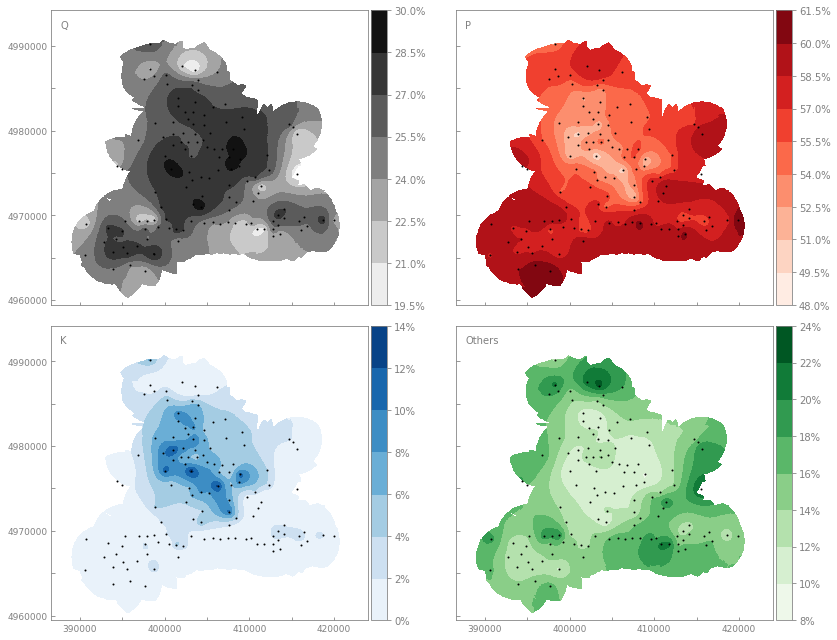

In [133]:
# Figure with 4 single mineral maps as subplots
plots.plot_contour_map_all(interpolated_modal_BM,
                           grid_wide_BM,
                               coordinates_utm_BM,
                               "BM",
                               title=f"radius={range_BM[0]}m masked {critical_distance_BM}m wide new2",
                               show_plot=True,
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=2,
                               skip_yaxis_label=2,
                               skip_xaxis_start=1,
                               skip_yaxis_start=1,
                               figsize=(12, 9),
                               ncols=2,
                               nrows=2,
                               sharex=True,
                               sharey=True)

In [59]:
interpolated_mineralogy_BM = preproc.load_obj("BM/interpolated_mineralogy_BM")

In [134]:
%%time
interpolated_mineralogy_BM = interpolated_reverse_clr_BM.copy()
interpolated_mineralogy_BM["QPAF"] = qapf.check_QAPF_region(interpolated_mineralogy_BM)

Wall time: 18.1 s


In [135]:
interpolated_mineralogy_BM["QPAF_numbers"] = interpolated_mineralogy_BM["QPAF"].map(qapf.QAPF_upper_regions_numbers)

In [136]:
preproc.save_obj(interpolated_mineralogy_BM, "BM/interpolated_mineralogy_BM")

In [60]:
interpolated_mineralogy_reshape_BM = np.reshape(interpolated_mineralogy_BM["QPAF_numbers"].values, (grid_wide_BM[1].shape[0], grid_wide_BM[0].shape[0]))

In [61]:
values_to_plot_BM = list(np.sort(interpolated_mineralogy_BM["QPAF_numbers"].unique()))[1:]
values_to_plot_BM

[6, 7]

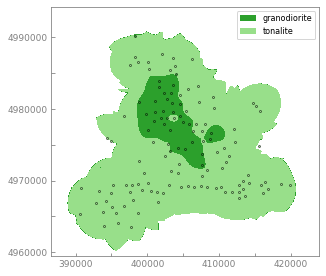

In [145]:
plots.plot_contour_map_interpolated_QAPF(interpolated_mineralogy_reshape_BM, grid_wide_BM, QAPF_to_plot_BM, "BM", values_to_plot=values_to_plot_BM,
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=True)

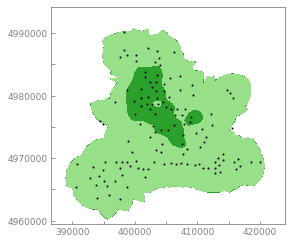

In [146]:
plots.plot_contour_map_interpolated_QAPF(interpolated_mineralogy_reshape_BM, grid_wide_BM, QAPF_to_plot_BM, "BM", values_to_plot=values_to_plot_BM,
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=False, no_legend=True)

## Contour plots theoretical nugget

In [62]:
nvalues_critical_distance_BM = variograms_theoretical_BM["PC01"].determine_mask_array(grid_wide_BM[0], grid_wide_BM[1], search_radius=critical_distance_BM)
mask_critical_distance_BM = nvalues_critical_distance_BM < 3
mask_critical_distance_BM.shape

(130, 2)
(270039, 2)
539 501


(501, 539)

In [63]:
mask_critical_distance_BM[mask_critical_distance_BM == 1].sum()

150989

In [64]:
interpolated_theoretical_12000_BM_dict = preproc.load_obj("BM/interpolated_theoretical_12000_wide_BM_dict")

In [133]:
%%time
interpolated_theoretical_12000_BM_parallel = Parallel(n_jobs=3)(delayed(
    OK_model.execute)('masked', 
                     grid_wide_BM[0], 
                     grid_wide_BM[1],
                     mask_critical_distance_BM,
                     n_closest_points=number_of_control_points_BM, 
                     search_radius=range_BM[0], 
                     backend='loop') for component, OK_model in variograms_theoretical_BM.items())

Wall time: 47.5 s


In [134]:
interpolated_theoretical_12000_BM_dict = {}
for i, item in enumerate(interpolated_theoretical_12000_BM_parallel, start=1):
    interpolated_theoretical_12000_BM_dict[f"PC0{i}"] = item

In [273]:
preproc.save_obj(interpolated_theoretical_12000_BM_dict, "BM/interpolated_theoretical_12000_wide_BM_dict")

In [65]:
interpolated_theoretical_12000_BM_array = postproc.convert_grid_to_array_of_scores(interpolated_theoretical_12000_BM_dict)
interpolated_theoretical_reverse_pca_BM = postproc.reverse_pca(pca_BM, interpolated_theoretical_12000_BM_array, mineralogy_clr_BM, n_comp=2)
interpolated_theoretical_reverse_clr_BM = postproc.reverse_clr(interpolated_theoretical_reverse_pca_BM, mineralogy_clr_BM)

1
2
3
(3, 501, 539)


In [66]:
assert grid_wide_BM[0].shape[0] * grid_wide_BM[1].shape[0] == np.sum(np.isclose(interpolated_theoretical_reverse_clr_BM.sum(axis=1), 0.0)) + \
                                                              np.sum(np.isclose(interpolated_theoretical_reverse_clr_BM.sum(axis=1), 100.0))

In [67]:
interpolated_theoretical_modal_BM = {}
for mineral in interpolated_theoretical_reverse_clr_BM.columns.tolist():
    interpolated_theoretical_modal_BM[mineral] = np.reshape(interpolated_theoretical_reverse_clr_BM.loc[:, mineral].values, (grid_wide_BM[1].shape[0], grid_wide_BM[0].shape[0]))

In [139]:
for mineral, interpolation in interpolated_theoretical_modal_BM.items(): 
    for variable in ["estimates"]:
        print(interpolation.shape)
        plots.plot_contour_map(interpolation,
                               grid_wide_BM,
                               coordinates_utm_BM,
                               "BM",
                               variable=variable,
                               title=f"{mineral} radius={range_BM[0]}m {variable} masked {critical_distance_BM}m wide theoretical new",
                               show_plot=False,
                               single_mineral=True,
                               mineral=mineral,                               
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=1,
                               skip_yaxis_label=2,
                               skip_xaxis_start=2,
                               skip_yaxis_start=1,)

(501, 539)
(501, 539)
(501, 539)
(501, 539)


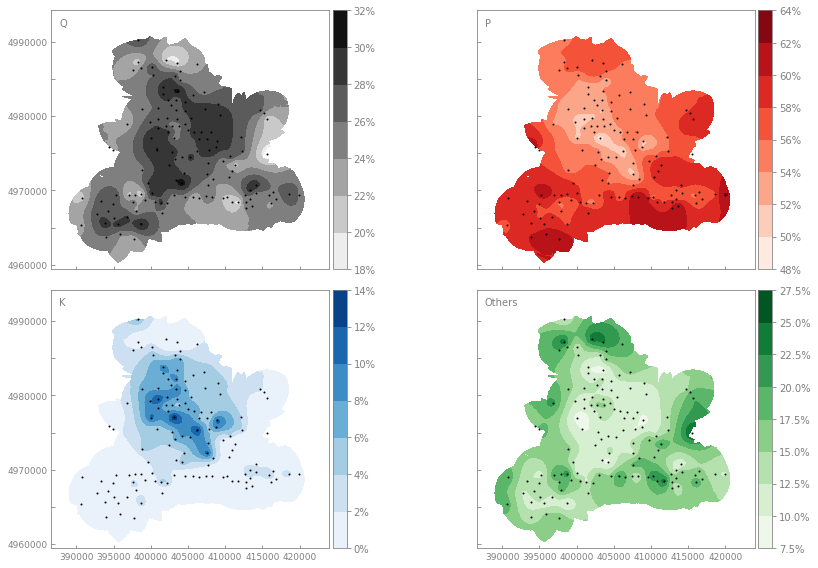

In [140]:
# Figure with 4 single mineral maps as subplots
plots.plot_contour_map_all(interpolated_theoretical_modal_BM,
                           grid_wide_BM,
                               coordinates_utm_BM,
                               "BM",
                               title=f"radius={range_BM[0]}m masked {critical_distance_BM}m wide theoretical new",
                               show_plot=True,
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=1,
                               skip_yaxis_label=2,
                               skip_xaxis_start=2,
                               skip_yaxis_start=1,
                               figsize=(13, 8),
                               ncols=2,
                               nrows=2,
                               sharex=True,
                               sharey=True)

In [68]:
interpolated_theoretical_mineralogy_BM = preproc.load_obj("BM/interpolated_theoretical_mineralogy_BM")

In [53]:
%%time
interpolated_theoretical_mineralogy_BM = interpolated_theoretical_reverse_clr_BM.copy()
interpolated_theoretical_mineralogy_BM["QPAF"] = qapf.check_QAPF_region(interpolated_theoretical_mineralogy_BM)

Wall time: 20.5 s


In [54]:
interpolated_theoretical_mineralogy_BM["QPAF_numbers"] = interpolated_theoretical_mineralogy_BM["QPAF"].map(qapf.QAPF_upper_regions_numbers)

In [55]:
preproc.save_obj(interpolated_theoretical_mineralogy_BM, "BM/interpolated_theoretical_mineralogy_BM")

In [69]:
interpolated_theoretical_mineralogy_reshape_BM = np.reshape(interpolated_theoretical_mineralogy_BM["QPAF_numbers"].values, (grid_wide_BM[1].shape[0], grid_wide_BM[0].shape[0]))

In [70]:
values_to_plot_theoretical_BM = list(np.sort(interpolated_theoretical_mineralogy_BM["QPAF_numbers"].unique()))[1:]
values_to_plot_theoretical_BM

[6, 7]

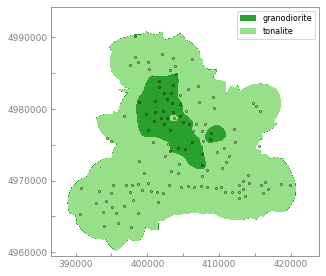

In [145]:
plots.plot_contour_map_interpolated_QAPF(interpolated_theoretical_mineralogy_reshape_BM, grid_wide_BM, QAPF_to_plot_BM, "BM", values_to_plot=values_to_plot_theoretical_BM,
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=True)

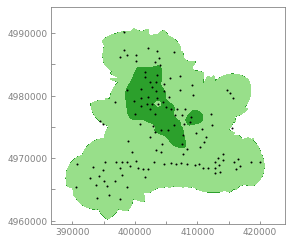

In [146]:
plots.plot_contour_map_interpolated_QAPF(interpolated_theoretical_mineralogy_reshape_BM, grid_wide_BM, QAPF_to_plot_BM, "BM", values_to_plot=values_to_plot_BM,
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=False, no_legend=True)

## Biplots

### Control points and high resolution grid replicates' nugget

In [147]:
control_points_BM = mineralogy_clr_BM.copy()
control_points_BM["QAPF_numbers"] = QAPF_to_plot_BM["QAPF"].map(plots.QAPF_upper_regions_numbers)
control_points_BM["Type"] = "Control points"
control_points_BM.shape
control_points_BM.head()

(130, 6)

Q         P         K    Others  QAPF_numbers            Type
1    0.470775  1.386235 -1.718185 -0.138825             7  Control points
105  0.656334  1.753327 -2.879783  0.470122             7  Control points
109  1.039742  1.901003 -3.398980  0.458235             7  Control points
110  1.252659  2.274829 -4.189759  0.662271             7  Control points
111  0.241731  0.956135 -0.630618 -0.567248             6  Control points

In [148]:
grid_predictions_BM = interpolated_reverse_pca_BM.copy()
grid_predictions_BM = pd.DataFrame(interpolated_reverse_pca_BM, columns=control_points_BM.columns[:-2])
grid_predictions_BM["QAPF_numbers"] = interpolated_mineralogy_BM["QPAF_numbers"]
grid_predictions_BM = grid_predictions_BM.dropna()
grid_predictions_BM["Type"] = "Grid points"
grid_predictions_BM.shape
grid_predictions_BM.head()

(119050, 6)

Q         P         K    Others  QAPF_numbers         Type
7137  1.016167  1.939716 -3.570594  0.614711             7  Grid points
7138  1.017529  1.941750 -3.576644  0.617365             7  Grid points
7675  1.016781  1.940190 -3.571392  0.614422             7  Grid points
7676  1.018234  1.942354 -3.577823  0.617234             7  Grid points
7677  1.019639  1.944455 -3.584075  0.619982             7  Grid points

In [149]:
grid_predictions_BM["QAPF_numbers"].unique()

array([7, 6], dtype=int64)

In [150]:
control_and_predictions_BM = pd.concat([control_points_BM, grid_predictions_BM])
control_and_predictions_BM.shape

(119180, 6)

In [151]:
control_and_predictions_pca_BM = preproc.pca(control_and_predictions_BM.iloc[:, :-2])
control_and_predictions_pca_df_BM = preproc.create_pca_df(control_and_predictions_pca_BM, control_and_predictions_BM.iloc[:, :-2])
control_and_predictions_pca_df_BM.head()

PC01      PC02      PC03          PC04
1   -0.585929  0.011475 -0.122086 -4.163336e-16
105  0.782556 -0.116672 -0.133864  2.220446e-16
109  1.341257  0.208478  0.009826  1.165734e-15
110  2.246533  0.367022 -0.076091  8.881784e-16
111 -1.849747 -0.033176 -0.054491  4.440892e-16

In [152]:
%%time
control_and_predictions_pca_df_BM["QAPF_numbers"] = control_and_predictions_BM["QAPF_numbers"]
control_and_predictions_pca_df_BM["QAPF_colors"] = control_and_predictions_pca_df_BM["QAPF_numbers"].map(plots.QAPF_upper_regions_numbers_vs_cmap)
control_and_predictions_pca_df_BM["QAPF_colors"] = control_and_predictions_pca_df_BM["QAPF_colors"].apply(lambda x: plots.get_colors(x))
control_and_predictions_pca_df_BM["Type"] = control_and_predictions_BM["Type"]

Wall time: 2.22 s


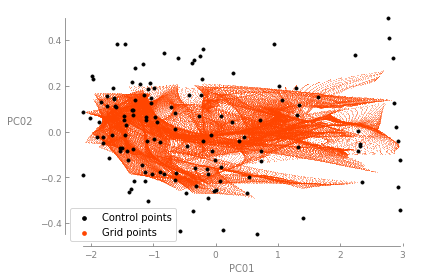

Wall time: 4.25 s


In [191]:
%%time
plots.biplot_control_and_grid(control_and_predictions_pca_df_BM, "BM", offsets=[0., 0., 0., 0.])

[-1.0, 0.0, 1.0, 2.0, 3.0]
[-0.5, 0.0, 0.5]


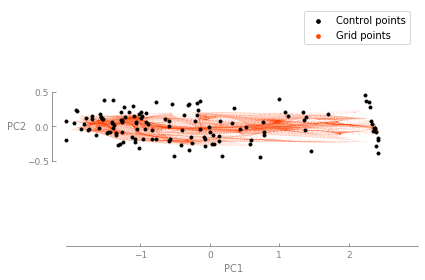

Wall time: 7.73 s


In [55]:
%%time
plots.biplot_control_and_grid(control_and_predictions_pca_df_BM, "BM", offsets=[0., 0., 0., 0.],
                              grid_point_size=0.1, xspacing=1, xformat="2.0f")

[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
[-0.5, 0.0, 0.5]


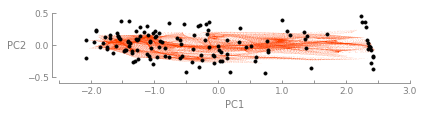

Wall time: 5.99 s


In [166]:
%%time
plots.biplot_control_and_grid(control_and_predictions_pca_df_BM, "BM", offsets=[0., 0., 0., 0.], extra_ticks=[[], [3.0], [], []],
                              grid_point_size=0.1, xspacing=0.5, xformat="2.1f", adjust='box', no_legend=True,
                              skip_xaxis_label=2, skip_xaxis_start=1)

[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
[-0.5, 0.0, 0.5]


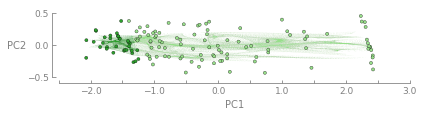

Wall time: 14.1 s


In [153]:
%%time
plots.biplot_control_and_grid_technicolor(control_and_predictions_pca_df_BM, "BM", offsets=[0., 0., 0., 0.], extra_ticks=[[], [3.0], [], []],
                                          grid_point_size=0.1, xspacing=0.5, xformat="2.1f", adjust='box', no_legend=True,
                                          skip_xaxis_label=2, skip_xaxis_start=1, axes_offset=0.1)

### Control points and high resolution grid theoretical

In [92]:
control_points_theoretical_BM = mineralogy_clr_BM.copy()
control_points_theoretical_BM["QAPF_numbers"] = QAPF_to_plot_BM["QAPF"].map(plots.QAPF_upper_regions_numbers)
control_points_theoretical_BM["Type"] = "Control points"
control_points_theoretical_BM.shape
control_points_theoretical_BM.head()

(130, 6)

Q         P         K    Others  QAPF_numbers            Type
1    0.470775  1.386235 -1.718185 -0.138825             7  Control points
105  0.656334  1.753327 -2.879783  0.470122             7  Control points
109  1.039742  1.901003 -3.398980  0.458235             7  Control points
110  1.252659  2.274829 -4.189759  0.662271             7  Control points
111  0.241731  0.956135 -0.630618 -0.567248             6  Control points

In [93]:
grid_predictions_theoretical_BM = interpolated_theoretical_reverse_pca_BM.copy()
grid_predictions_theoretical_BM = pd.DataFrame(grid_predictions_theoretical_BM, columns=control_points_theoretical_BM.columns[:-2])
grid_predictions_theoretical_BM["QAPF_numbers"] = interpolated_theoretical_mineralogy_BM["QPAF_numbers"]
grid_predictions_theoretical_BM = grid_predictions_theoretical_BM.dropna()
grid_predictions_theoretical_BM["Type"] = "Grid points"
grid_predictions_theoretical_BM.shape
grid_predictions_theoretical_BM.head()

(119050, 6)

Q         P         K    Others  QAPF_numbers         Type
7137  1.009722  1.940186 -3.585922  0.636015             7  Grid points
7138  1.011031  1.942225 -3.592107  0.638851             7  Grid points
7675  1.010450  1.940711 -3.586710  0.635549             7  Grid points
7676  1.011844  1.942880 -3.593282  0.638558             7  Grid points
7677  1.013189  1.944984 -3.599672  0.641500             7  Grid points

In [94]:
grid_predictions_theoretical_BM["QAPF_numbers"].unique()

array([7, 6], dtype=int64)

In [95]:
control_and_predictions_theoretical_BM = pd.concat([control_points_theoretical_BM, grid_predictions_theoretical_BM])
control_and_predictions_theoretical_BM.shape

(119180, 6)

In [96]:
control_and_predictions_pca_theoretical_BM = preproc.pca(control_and_predictions_theoretical_BM.iloc[:, :-2])
control_and_predictions_pca_df_theoretical_BM = preproc.create_pca_df(control_and_predictions_pca_theoretical_BM, control_and_predictions_theoretical_BM.iloc[:, :-2])
control_and_predictions_pca_df_theoretical_BM.head()

PC01      PC02      PC03          PC04
1   -0.589085 -0.016656 -0.122086 -2.664535e-15
105  0.778271  0.123031 -0.133864 -3.219647e-15
109  1.339695 -0.197394  0.009826  0.000000e+00
110  2.246276 -0.348296 -0.076091 -9.992007e-16
111 -1.853234  0.017332 -0.054491 -2.664535e-15

In [97]:
%%time
control_and_predictions_pca_df_theoretical_BM["QAPF_numbers"] = control_and_predictions_theoretical_BM["QAPF_numbers"]
control_and_predictions_pca_df_theoretical_BM["QAPF_colors"] = control_and_predictions_pca_df_theoretical_BM["QAPF_numbers"].map(plots.QAPF_upper_regions_numbers_vs_cmap)
control_and_predictions_pca_df_theoretical_BM["QAPF_colors"] = control_and_predictions_pca_df_theoretical_BM["QAPF_colors"].apply(lambda x: plots.get_colors(x))
control_and_predictions_pca_df_theoretical_BM["Type"] = control_and_predictions_theoretical_BM["Type"]

Wall time: 2.48 s


[-1.0, 0.0, 1.0, 2.0, 3.0]
[-0.5, 0.0, 0.5]


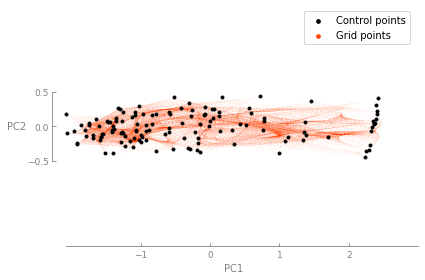

Wall time: 7.8 s


In [68]:
%%time
plots.biplot_control_and_grid(control_and_predictions_pca_df_theoretical_BM, "BM_theoretical", 
                              offsets=[0., 0., 0., 0.], grid_point_size=0.1)

In [100]:
control_and_predictions_pca_df_theoretical_BM_flipped = control_and_predictions_pca_df_theoretical_BM.copy()
control_and_predictions_pca_df_theoretical_BM_flipped["PC02"] = np.negative(control_and_predictions_pca_df_theoretical_BM_flipped["PC02"])

[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
[-0.5, 0.0, 0.5]


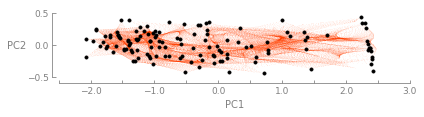

Wall time: 5.86 s


In [169]:
%%time
plots.biplot_control_and_grid(control_and_predictions_pca_df_theoretical_BM_flipped, "BM_theoretical", extra_ticks=[[], [3.0], [], []],
                              offsets=[0., 0., 0., 0.], grid_point_size=0.1, xspacing=0.5, xformat="2.1f", adjust='box', no_legend=True,
                              skip_xaxis_label=2, skip_xaxis_start=1)

[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
[-0.5, 0.0, 0.5]


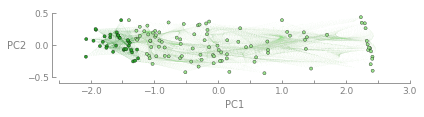

Wall time: 16.4 s


In [105]:
%%time
plots.biplot_control_and_grid_technicolor(control_and_predictions_pca_df_theoretical_BM_flipped, "BM_theoretical", extra_ticks=[[], [3.0], [], []],
                                          offsets=[0., 0., 0., 0.], grid_point_size=0.1, xspacing=0.5, xformat="2.1f", adjust='box', no_legend=True,
                                          skip_xaxis_label=2, skip_xaxis_start=1, axes_offset=0.1)

### Control points and predictions replicates' nugget

In [154]:
control_points_BM = mineralogy_clr_BM.copy()
control_points_BM["Type"] = "Control points"
control_points_BM.shape

(130, 5)

In [155]:
solution_predictions_BM = solutions_clr_BM["2_replicates_12000"].copy()
solution_predictions_BM["Type"] = "CV predictions"
solution_predictions_BM.shape

(130, 5)

In [156]:
control_and_solutions_BM = pd.concat([control_points_BM, solution_predictions_BM])

In [157]:
control_and_solutions_pca_BM = preproc.pca(control_and_solutions_BM.iloc[:, :-1])
control_and_solutions_pca_df_BM = preproc.create_pca_df(control_and_solutions_pca_BM, control_and_solutions_BM.iloc[:, :-1])
control_and_solutions_pca_df_BM.head()

PC01      PC02      PC03          PC04
1   -0.276411 -0.000868 -0.122086 -6.245005e-17
105  1.093171 -0.116713 -0.133864  3.330669e-16
109  1.648928  0.213444  0.009826 -1.110223e-16
110  2.552743  0.380116 -0.076091 -4.440892e-16
111 -1.539776 -0.056873 -0.054491  8.881784e-16

In [158]:
control_and_solutions_pca_df_BM["Type"] = control_and_solutions_BM["Type"]

In [159]:
control_and_solutions_pca_df_BM["Type"].unique()

array(['Control points', 'CV predictions'], dtype=object)

[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
[-0.5, 0.0, 0.5]


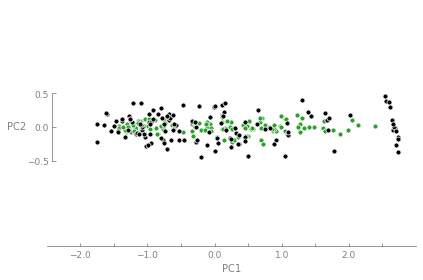

In [160]:
plots.biplot_control_and_solutions(control_and_solutions_pca_df_BM, "BM", offsets=[0., 0., 0., 0.], 
                                   adjust='datalim', no_legend=True, extra_ticks=[[-2.0, -2.5], [3.0], [], []],
                                   xspacing=0.5, xformat="2.1f", skip_xaxis_label=2, skip_xaxis_start=1)

[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
[-0.5, 0.0, 0.5]


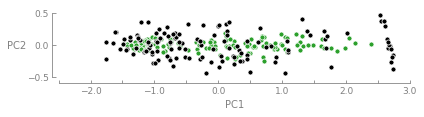

In [161]:
plots.biplot_control_and_solutions(control_and_solutions_pca_df_BM, "BM", offsets=[0., 0., 0., 0.], 
                                   adjust='box', no_legend=True, extra_ticks=[[-2.0, -2.5], [3.0], [], []],
                                   xspacing=0.5, xformat="2.1f", skip_xaxis_label=2, skip_xaxis_start=1)

### Control points and predictions theoretical nugget

In [151]:
control_points_BM = mineralogy_clr_BM.copy()
control_points_BM["Type"] = "Control points"
control_points_BM.shape

(130, 5)

In [152]:
solution_predictions_theoretical_BM = solutions_clr_BM["2_theoretical_12000"].copy()
solution_predictions_theoretical_BM["Type"] = "CV predictions"
solution_predictions_theoretical_BM.shape

(130, 5)

In [153]:
control_and_solutions_theoretical_BM = pd.concat([control_points_BM, solution_predictions_theoretical_BM])

In [154]:
control_and_solutions_pca_theoretical_BM = preproc.pca(control_and_solutions_theoretical_BM.iloc[:, :-1])
control_and_solutions_pca_df_theoretical_BM = preproc.create_pca_df(control_and_solutions_pca_theoretical_BM, control_and_solutions_theoretical_BM.iloc[:, :-1])
control_and_solutions_pca_df_theoretical_BM.head()

PC01      PC02      PC03          PC04
1   -0.276346 -0.001188 -0.122086  1.040834e-16
105  1.093357 -0.115589 -0.133864  5.551115e-16
109  1.648766  0.215154  0.009826  1.665335e-16
110  2.552404  0.382780 -0.076091  1.110223e-16
111 -1.539651 -0.058525 -0.054491  9.436896e-16

In [155]:
control_and_solutions_pca_df_theoretical_BM["Type"] = control_and_solutions_theoretical_BM["Type"]

In [156]:
control_and_solutions_pca_df_theoretical_BM["Type"].unique()

array(['Control points', 'CV predictions'], dtype=object)

[-2.0, -1.0, 0.0, 1.0, 2.0, 3.0]
[-0.5, 0.0, 0.5]


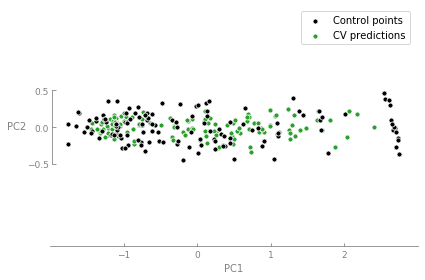

In [157]:
plots.biplot_control_and_solutions(control_and_solutions_pca_df_theoretical_BM, "BM_theoretical", offsets=[0., 0., 0., 0.])

[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
[-0.5, 0.0, 0.5]


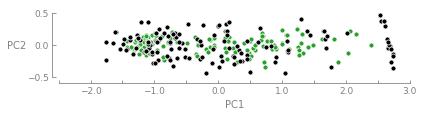

In [159]:
plots.biplot_control_and_solutions(control_and_solutions_pca_df_theoretical_BM, "BM_theoretical", offsets=[0., 0., 0., 0.], 
                                   adjust='box', no_legend=True, extra_ticks=[[-2.0, -2.5], [3.0], [], []],
                                   xspacing=0.5, xformat="2.1f", skip_xaxis_label=2, skip_xaxis_start=1)

### Residuals replicates' nugget

In [162]:
residuals_predictions_BM = residuals_pca_df_BM["2_replicates_12000"].copy()

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]
[-0.5, 0.0, 0.5]


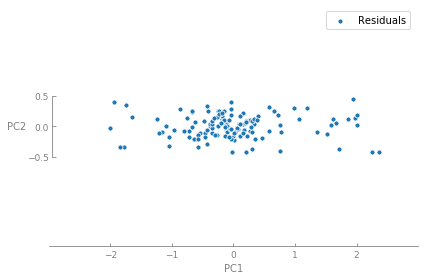

In [161]:
plots.biplot_residuals(residuals_predictions_BM, "BM", offsets=[0., 0., 0., 0.])

[-2.5, -2.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
[-0.5, 0.0, 0.5]


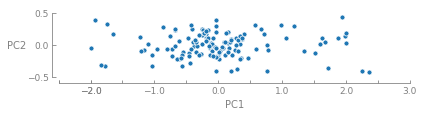

In [163]:
plots.biplot_residuals(residuals_predictions_BM, "BM", offsets=[0., 0., 0., 0.], adjust='box',
                       no_legend=True, extra_ticks=[[-2.0, -2.5], [3.0], [], []],
                       xspacing=0.5, xformat="2.1f", skip_xaxis_label=2, skip_xaxis_start=1)

### Residuals theoretical nugget

In [163]:
residuals_predictions_theoretical_BM = residuals_pca_df_BM["2_theoretical_12000"].copy()

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]
[-0.5, 0.0, 0.5]


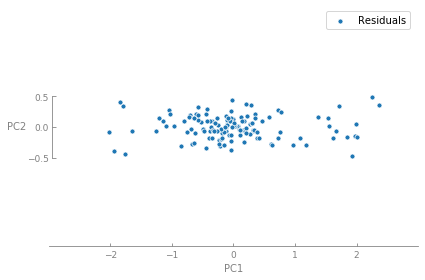

In [164]:
plots.biplot_residuals(residuals_predictions_theoretical_BM, "BM_theoretical", offsets=[0., 0., 0., 0.])

[-2.5, -2.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
[-0.5, 0.0, 0.5]


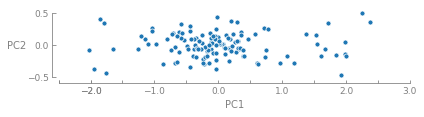

In [165]:
plots.biplot_residuals(residuals_predictions_theoretical_BM, "BM_theoretical", offsets=[0., 0., 0., 0.], adjust='box',
                       no_legend=True, extra_ticks=[[-2.0, -2.5], [3.0], [], []],
                       xspacing=0.5, xformat="2.1f", skip_xaxis_label=2, skip_xaxis_start=1)

## Simulations

### Number of samples - mean composition of pluton

In [71]:
interpolated_pca_mean_BM = np.nanmean(interpolated_theoretical_12000_BM_array, axis=0)
# interpolated_pca_mean_BM = interpolated_pca_mean_BM.reshape((4, 1))

In [72]:
reverse_interpolated_clr_mean_BM = postproc.reverse_pca(pca_BM, interpolated_pca_mean_BM.reshape(1, 3), mineralogy_clr_BM, n_comp=2)

In [73]:
reverse_interpolated_clr_mean_BM

array([[ 0.65462751,  1.46031301, -2.22796181,  0.11302129]])

In [74]:
interpolated_clr_mean_BM = np.nanmean(interpolated_reverse_pca_BM, axis=0)
interpolated_clr_mean_BM = interpolated_clr_mean_BM.reshape(1, 4)

In [75]:
interpolated_clr_mean_BM

array([[ 0.65411066,  1.4594268 , -2.22516767,  0.11163021]])

____

In [76]:
n_comp = 2

CV_errors = {}

for i in range(1, n_comp + 1):
    CV_errors[f"PC0{i}"] = CV_results_replicates_BM[f"PC0{i}"].query("param_variogram_model == 'exponential' & param_search_radius == 12000")["mean_test_score"].values[0]

In [77]:
CV_errors

{'PC01': 0.7104539749138654, 'PC02': 0.03677876818495128}

In [78]:
%%time
simulation_samples_BM = \
    Parallel(n_jobs=-1)(delayed(sim.create_random_samples)
                               (variograms_replicates_BM, 
                               critical_distance_BM,
                               n, 
                               10000,
                               n_comp=n_comp,
                               grid=grid_wide_BM,
                               mask=mask_critical_distance_BM,
                               pca=pca_BM,
                               clr=mineralogy_clr_BM,
                               CV_errors=CV_errors) for n in range(100))

Wall time: 1min 36s


In [81]:
random_samples_BM = [item[0][0] for item in simulation_samples_BM]
random_locations_BM = [item[1] for item in simulation_samples_BM]

In [82]:
random_samples_BM = np.array(random_samples_BM)

In [83]:
random_samples_BM.shape

(100, 10000, 4)

In [84]:
random_locations_BM = np.array(random_locations_BM).reshape(100, 2, 10000)

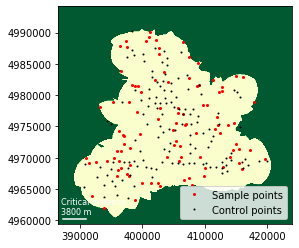

In [191]:
# Plot mask
plt.contourf(grid_wide_BM[0], grid_wide_BM[1], 
             mask_critical_distance_BM, cmap="YlGn")

# Plot random sample locations
# first index specifies nrun, second one 'X' or 'Y' coordinates
plt.plot(random_locations_BM[1][0][:100], random_locations_BM[1][1][:100], 
         marker='o', c='r', linestyle='None', markersize=2, label="Sample points")

# Plot control points
plt.plot(coordinates_utm_BM["X"], coordinates_utm_BM["Y"], 
         c='k', linestyle='None', marker='.', markersize=2, label="Control points")

# Plot critical distance as white line
plt.plot([grid_wide_BM[0][10], grid_wide_BM[0][10] + critical_distance_BM], 
         [grid_wide_BM[1][10], grid_wide_BM[1][10]], 
         c='w')
plt.text(0.01, 0.08, f"Critical distance\n{critical_distance_BM} m", 
         transform = plt.gca().transAxes, color='w', fontsize=8, va='center')

plt.legend()

plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("../_FIGURES/simulations/BM_example_sampling.pdf")

plt.show();

____

In [85]:
nugget_theoretical_BM_total = nugget_theoretical_BM.sum()
nugget_theoretical_BM_total

0.004742550856577889

In [86]:
nugget_replicates_BM_total = nugget_replicates_BM.sum()
nugget_replicates_BM_total

0.04260823734572347

In [87]:
nugget_theoretical_N2000 = krigingtools.calculate_theoretical_nugget(k=4, N=2000)

In [88]:
variances_samples_BM = np.empty(100)

for n in range(100):
    variances_samples_BM[n] = random_samples_BM[n].var(axis=0).sum()

In [89]:
total_variance_BM = variances_samples_BM.mean()

In [90]:
total_variance_BM

1.9833914421354095

In [92]:
sos_mean_results_BM = preproc.load_obj("BM/sos_mean_results_BM")

FileNotFoundError: [Errno 2] No such file or directory: '../_DATA/_obj/BM/sos_mean_results_BM.pkl'

In [91]:
%%time
n_runs = 100
counter_results_BM = {}
sos_mean_results_BM = {}

for sample_size in range(5, random_samples_BM.shape[1] + 1):
#     print(sample_size)
    # Set counter to n_runs=100 to subtract all 'h0reject=True' indicating significant tests.
    # The remaining value of 'counter' thus represents the number of non-significant tests.
    counter = n_runs
    sos_all = []
    for n in range(n_runs):
#         if sample_size == 143:
#             print(n)
        sos = np.sum((reverse_interpolated_clr_mean_BM - random_samples_BM[n][:sample_size].mean(axis=0)) ** 2)
        sos_all.append(sos)
        counter -= sos > nugget_theoretical_BM

    counter_results_BM[sample_size] = counter
    sos_mean_results_BM[sample_size] = np.mean(sos_all)

Wall time: 1min 34s


In [199]:
preproc.save_obj(sos_mean_results_BM, "BM/sos_mean_results_BM")

In [106]:
from scipy.optimize import curve_fit

x_data_to_fit = np.array(list(sos_mean_results_BM.keys()))
y_data_to_fit = np.array(list(sos_mean_results_BM.values()))

# Exponential fitting
e_opt, e_cov = curve_fit(tb.simple_exponential_fit, x_data_to_fit, y_data_to_fit, p0=(0.1, 1e-3))
e_opt

# Exponential fit calculation
fit_exponential =  tb.simple_exponential_fit(x_data_to_fit, *e_opt)

AttributeError: module 'toolbox.toolbox' has no attribute 'simple_exponential_fit'

In [96]:
from scipy.optimize import curve_fit

x_data_to_fit = np.array(list(sos_mean_results_BM.keys()))
y_data_to_fit = np.array(list(sos_mean_results_BM.values()))

# Reciprocal fit
r_opt, r_cov = curve_fit(tb.reciprocal_fit, x_data_to_fit, y_data_to_fit)
r_opt

# Reciprocal fit calculation
fit_reciprocal =  tb.reciprocal_fit(x_data_to_fit, *r_opt)

array([1.79037733e+00, 9.41520587e-06])

(395,)
-8.0 400
[  0.  33. 130. 200. 308. 400.]
[0, 33, 130, None, 308, 400]


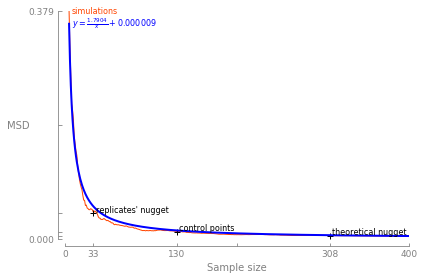

([308, 130, 33],
 [0.004742550856577889, 0.011894696345922226, 0.04260823734572347])

In [104]:
plots.plot_simulation_results(sos_mean_results_BM, 
                              "BM", 
                              nugget_theoretical_BM_total, 
                              number_of_control_points_BM, 
                              nugget_replicates=nugget_replicates_BM_total, 
                              xmax=400,
                              text_offsets=[3, 0.002],
                              fit=fit_reciprocal,
                              fit_params=r_opt,
                              fit_mode='reciprocal',
                              inverse=False)

In [92]:
from scipy.optimize import curve_fit

x_data_to_fit = np.array(list(sos_mean_results_BM.keys()))
y_data_to_fit = np.array(list(sos_mean_results_BM.values()))

# Reciprocal fit
r2_opt, r2_cov = curve_fit(tb.reciprocal2_fit, x_data_to_fit, y_data_to_fit, p0=[1, -1])
r2_opt

# Reciprocal fit calculation
fit_reciprocal2 =  tb.reciprocal2_fit(x_data_to_fit, *r2_opt)

array([ 2.45748583, -1.07915015])

(395,)
-8.0 400
[  0.  38. 130. 200. 356. 400.]
[0, 38, 130, None, 356, 400]


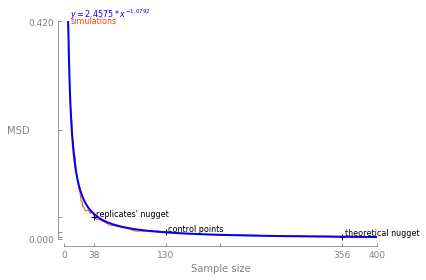

([356, 130, 38],
 [0.004742550856577889, 0.01370457020236094, 0.04260823734572347])

In [93]:
plots.plot_simulation_results(sos_mean_results_BM, 
                              "BM", 
                              nugget_theoretical_BM_total, 
                              number_of_control_points_BM, 
                              nugget_replicates=nugget_replicates_BM_total, 
                              xmax=400,
                              text_offsets=[3, 0.002],
                              fit=fit_reciprocal2,
                              fit_params=r2_opt,
                              fit_mode='reciprocal2',
                              inverse=False)

In [102]:
from scipy.optimize import curve_fit

x_data_to_fit = 1 / np.array(list(sos_mean_results_BM.keys()))
y_data_to_fit = np.array(list(sos_mean_results_BM.values()))

# Reciprocal fit
l_opt, l_cov = curve_fit(tb.linear_fit, x_data_to_fit, y_data_to_fit)
l_opt

# Reciprocal fit calculation
fit_linear =  tb.linear_fit(x_data_to_fit, *l_opt)

array([1.79037733e+00, 9.41520587e-06])

(395,)
0.125 0.0025
[0, 0.125]
[0.         0.00324675 0.00769231 0.03030303 0.125     ]
[  0.   8.  33. 130. 308.]
[0, '$\\frac{1}{308}$', '$\\frac{1}{130}$', '$\\frac{1}{33}$', '$\\frac{1}{8}$']


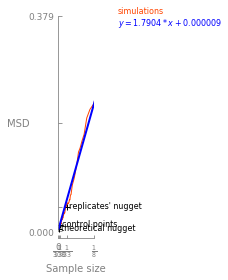

([308, 130, 33],
 [0.004742550856577889, 0.011894696345922226, 0.04260823734572347])

In [106]:
plots.plot_simulation_results(sos_mean_results_BM, 
                              "BM", 
                              nugget_theoretical_BM_total, 
                              number_of_control_points_BM, 
                              nugget_replicates=nugget_replicates_BM_total, 
                              xmax=400,
                              text_offsets=[0.007, -0.002],
                              fit=fit_linear,
                              fit_params=l_opt,
                              fit_mode='linear',
                              inverse=True)

In [107]:
from scipy.optimize import curve_fit

x_data_to_fit = 1 / np.array(list(sos_mean_results_BM.keys()))
y_data_to_fit = np.array(list(sos_mean_results_BM.values()))

# Reciprocal fit
l2_opt, l2_cov = curve_fit(tb.linear2_fit, x_data_to_fit, y_data_to_fit)
l2_opt

# Reciprocal fit calculation
fit_linear2 =  tb.linear2_fit(x_data_to_fit, *l2_opt)

array([2.30021788e+00, 1.10464307e+00, 3.49774729e-04])

(395,)
0.125 0.0025
[0, 0.125]
[0.         0.00324675 0.00769231 0.03030303 0.125     ]
[  0.   8.  33. 130. 308.]
[0, '$\\frac{1}{308}$', '$\\frac{1}{130}$', '$\\frac{1}{33}$', '$\\frac{1}{8}$']


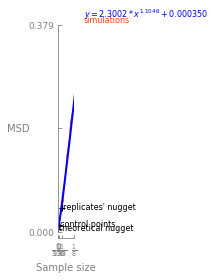

([308, 130, 33],
 [0.004742550856577889, 0.011894696345922226, 0.04260823734572347])

In [108]:
plots.plot_simulation_results(sos_mean_results_BM, 
                              "BM", 
                              nugget_theoretical_BM_total, 
                              number_of_control_points_BM, 
                              nugget_replicates=nugget_replicates_BM_total, 
                              xmax=400,
                              text_offsets=[0.007, -0.002],
                              fit=fit_linear2,
                              fit_params=l2_opt,
                              fit_mode='linear2',
                              inverse=True)

In [94]:
sample_size_of_interest = {"number_of_control_points": number_of_control_points_BM,
                           "2000_samples": 2000}

In [95]:
MSD_of_interest = {"p_02.5": 0.0199051,
                     "p_50.0": 0.0271522,
                     "p_97.5": 0.0370380,
                     "theoretical_nugget_universal": nugget_theoretical_N2000,
                     "theoretical_nugget_pluton": nugget_theoretical_BM_total,}

In [96]:
a = r2_opt[0]
b = r2_opt[1]
# c = r2_opt[2]
c = 0

In [97]:
sample_size_calc = {}

for key, value in MSD_of_interest.items():
    sample_size_calc[key] = ((value - c) / a) ** (1/b)

In [98]:
MSD_calc = {}

for key, value in sample_size_of_interest.items():
    MSD_calc[key] =  a * value ** b + c

In [99]:
from scipy.stats import spearmanr
spearman_corr = spearmanr(y_data_to_fit, fit_reciprocal2)[0]
spearman_corr

0.9973108263033142

In [100]:
total_variance_control_points = mineralogy_clr_BM.var(axis=0).sum()

In [101]:
BM_simulation_results = {"sample_sizes": [sample_size_calc["p_97.5"], 
                                          sample_size_calc["p_50.0"],
                                          sample_size_calc["p_02.5"],
                                          sample_size_calc["theoretical_nugget_universal"],
                                          sample_size_calc["theoretical_nugget_pluton"],
                                          number_of_control_points_BM,
                                          2000],
                        "MSD": [MSD_of_interest["p_97.5"],
                                MSD_of_interest["p_50.0"],
                                MSD_of_interest["p_02.5"],
                                MSD_of_interest["theoretical_nugget_universal"],
                                MSD_of_interest["theoretical_nugget_pluton"],
                                MSD_calc["number_of_control_points"],
                                MSD_calc["2000_samples"]],
                        "pluton_area_m2": pluton_area_m2,
                        "pluton_area_km2": pluton_area_km2,
                        "total_variance": total_variance_BM,
                        "total_variance_cp": total_variance_control_points, 
                        "model_coeffs": [r2_opt[0], r2_opt[1]],
                        "model_spearmancorr": spearman_corr}

In [102]:
BM_simulation_results

{'sample_sizes': [48.77761667838632,
  65.03888252197088,
  86.7209161009595,
  327.63164980185167,
  327.63164980185167,
  130,
  2000],
 'MSD': [0.037038,
  0.0271522,
  0.0199051,
  0.004742550856577889,
  0.004742550856577889,
  0.012859637557937108,
  0.0006732618326373925],
 'pluton_area_m2': 575518232.0448455,
 'pluton_area_km2': 575.5182320448455,
 'total_variance': 1.9833914421354095,
 'total_variance_cp': 1.7085230850278583,
 'model_coeffs': [2.4574858263040658, -1.0791501535751034],
 'model_spearmancorr': 0.9973108263033142}

In [211]:
preproc.save_obj(BM_simulation_results, "BM/BM_simulation_results")

____

In [212]:
random_chosen_samples = random_samples_BM[0][np.random.choice(random_samples_BM[0].shape[0], 130, replace=False)]

In [213]:
subset = pd.DataFrame(np.append(mineralogy_clr_BM.values, random_chosen_samples, axis=0))

In [214]:
subset["type"] = 0
subset.iloc[:130, -1] = "Control_points"
subset.iloc[130:, -1] = "Simulations"

In [215]:
subset_pca = preproc.pca(subset.iloc[:, :-1])

In [216]:
subset_pca_df = preproc.create_pca_df(subset_pca, subset.iloc[:, :-1])

In [217]:
subset_pca_df["type"] = subset["type"]

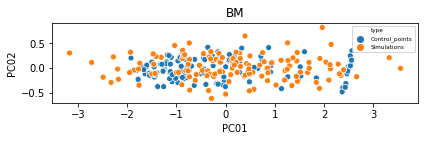

In [218]:
fig, ax = plt.subplots()
sns.scatterplot(x="PC01", y="PC02", data=subset_pca_df, hue="type")
ax.set_aspect("equal")
plt.title("BM")
plt.legend(fontsize='xx-small')
plt.tight_layout()
plt.savefig("../_FIGURES/simulations/BM_simulations_biplot_variance_test.pdf", 
            bbox_inches='tight')
plt.show();

In [219]:
random_chosen_samples = random_samples_BM[0][np.random.choice(random_samples_BM[0].shape[0], 10000, replace=False)]

In [220]:
subset = pd.DataFrame(np.append(mineralogy_clr_BM.values, random_chosen_samples, axis=0))

In [221]:
subset["type"] = 0
subset.iloc[:130, -1] = "Control_points"
subset.iloc[130:, -1] = "Simulations"

In [222]:
subset_pca = preproc.pca(subset.iloc[:, :-1])

In [223]:
subset_pca_df = preproc.create_pca_df(subset_pca, subset.iloc[:, :-1])

In [224]:
subset_pca_df["type"] = subset["type"]

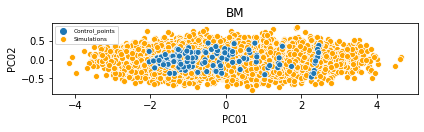

In [225]:
fig, ax = plt.subplots()
sns.scatterplot(x="PC01", y="PC02", data=subset_pca_df.query("type == 'Simulations'"), color="orange", label="Simulations")
sns.scatterplot(x="PC01", y="PC02", data=subset_pca_df.query("type == 'Control_points'"), hue="type")
ax.set_aspect("equal")
plt.title("BM")
handles, labels = ax.get_legend_handles_labels()
handles = [handles[-1], handles[0]]
labels = [labels[-1], labels[0]]
lgnd = ax.legend(handles, labels, loc='best', fontsize="xx-small")
plt.tight_layout()
plt.savefig("../_FIGURES/simulations/BM_simulations_biplot_variance_test_10000.pdf", 
            bbox_inches='tight')
plt.savefig("../_FIGURES/simulations/BM_simulations_biplot_variance_test_10000.png", 
            bbox_inches='tight', dpi=900)
plt.show();

____